In [1]:
import os
import sys
import torch
from transformers import BertTokenizer,squad_convert_examples_to_features, AutoConfig, AutoModelForQuestionAnswering
from transformers.data.processors.squad import SquadV2Processor
from torch.utils.data import DataLoader, RandomSampler
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
#from ProbeAttention import *

In [2]:
model_dir = 'bert-base-uncased'
model_prefix = 'bert-base-uncased'
data_dir = ''
data_file = 'train-v2.0.json'
max_seq_length = 384
res_size = 3
non_linear = "gelu"
project_dim = 200
layers = 12
hidden_dim = 768
epochs = 5
batch_size = 8
adam_epsilon = 1e-8
max_grad_norm = 0.1
dropout_r = 0.3
lr = 3e-5

In [3]:
# GPU
if torch.cuda.is_available():       
    device = 'cuda'
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = 'cpu'

# Tokenizer
tokenizer = BertTokenizer.from_pretrained(model_prefix)

# Extract examples
processor = SquadV2Processor()
train_examples = processor.get_train_examples(data_dir=data_dir, filename=data_file)

We will use the GPU: GeForce GTX 1050 Ti with Max-Q Design


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 442/442 [00:42<00:00, 10.43it/s]


In [4]:
# Extract train features
print("Loading train features")
train_features, train_dataset = squad_convert_examples_to_features(
    examples=train_examples,
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    doc_stride=128,
    max_query_length=64,
    is_training=True,
    return_dataset="pt",
    threads=1,
)

Loading train features


add example index and unique id: 100%|██████████████████████████████████████████████████████████████████████████████| 130319/130319 [00:00<00:00, 1146185.45it/s]


In [5]:
# Initialize model
#from ProbeAttention import *

config = AutoConfig.from_pretrained(model_prefix, output_hidden_states = True)
model = AutoModelForQuestionAnswering.from_pretrained(model_prefix, config = config)

# multi-gpu evaluate one at here
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForQuestionAnswering: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased a

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AdamW
import numpy as np

class Adapter(nn.Module):
    def __init__(self, in_dim, project_dim, non_linear, p = dropout_r, max_seq = max_seq_length):
        super(Adapter, self).__init__()        
        assert non_linear in ["relu","gelu","tanh"]
        
        if (non_linear == "relu"):
            self.non_linear = nn.ReLU()
        elif (non_linear == "gelu"):
            self.non_linear = nn.GELU()
        elif (non_linear == "tanh"):
            self.non_linear = nn.Tanh()
                
        self.project_down = nn.Linear(in_dim, project_dim)
        self.project_up = nn.Linear(project_dim, in_dim)
        self.dropout = nn.Dropout(p=p)
        self.batchnorm = nn.BatchNorm1d(max_seq)
        self.layernorm = nn.LayerNorm(in_dim, max_seq)
        
    def forward(self, h):
        h = self.project_down(h)
        #print(h.size()) ->　(8,384,200)
        h = self.batchnorm(h)
        h = self.non_linear(h)
        h = self.dropout(h)
        h = self.project_up(h)
        h = self.layernorm(h)
        
        return h

class ResAdapter(nn.Module):
    def __init__(self, in_dim, project_dim, non_linear, res_size, max_seq=max_seq_length):
        super(ResAdapter, self).__init__()
        
        self.res_size = res_size
        self.adapter_list = nn.ModuleList([Adapter(in_dim, project_dim, non_linear) for i in range(res_size)])
        
    def forward(self, h_list, h_last=None):
        h = torch.zeros(h_list[0].size()).to(device)
        
        if (h_last != None):
            h = h_last
            
        for i in range(res_size):
            if (i == 0):
                h = self.adapter_list[i](h_list[i]+h) + h_list[i+1]
            elif (i==res_size-1):
                h = self.adapter_list[i](h) + h_list[0]
            else:
                h = self.adapter_list[i](h) + h_list[i+1]
        
        return h

class ResAdapterModel(nn.Module):
    def __init__(self, in_dim, project_dim, non_linear, res_size, max_seq):
        super(ResAdapterModel, self).__init__()
        assert (12 % res_size == 0)
        
        self.res_size = res_size
        self.res_list = nn.ModuleList([ResAdapter(in_dim, project_dim, non_linear, res_size) for i in range(12//res_size)])
        self.linear = nn.Linear(in_dim, 1)
    
    def forward(self, all_h):
        h = torch.zeros(all_h[0].size()).to(device)
        
        h_list = []
        for i in range(12):
            h_list.append(all_h[i])
            if (i%res_size==res_size-1):
                h = self.res_list[i//res_size](h_list, h)
                h_list = []
        return self.linear(h).unsqueeze(0)

In [7]:
# Initialize adaptors
print("Initializing adaptors")
adaptor_s = ResAdapterModel(hidden_dim, project_dim, non_linear, res_size, max_seq_length)
adaptor_e = ResAdapterModel(hidden_dim, project_dim, non_linear, res_size, max_seq_length)

adaptor_s.to(device)
adaptor_e.to(device)

start_optimizer = AdamW(adaptor_s.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)
end_optimizer = AdamW(adaptor_e.parameters(), lr=lr, eps=adam_epsilon, correct_bias=False)

Initializing adaptors


In [8]:
# minimum loss
min_loss = 1000000000
    
# start & end hidden state
start_hidden={}
end_hidden={}

# create results folder
if not os.path.exists('results'):
        os.mkdir('results')
        
if not os.path.exists('results'+'/'+ model_prefix):
        os.mkdir('results'+'/'+ model_prefix)

Iteration:   0%|                                                                                                                       | 0/16493 [00:00<?, ?it/s]

Training epoch: 1


Iteration:   1%|▋                                                                                                          | 100/16493 [01:39<5:46:34,  1.27s/it]

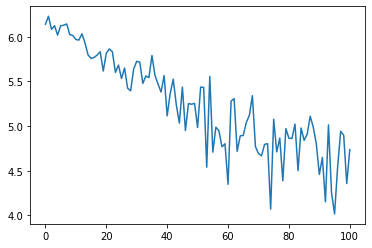

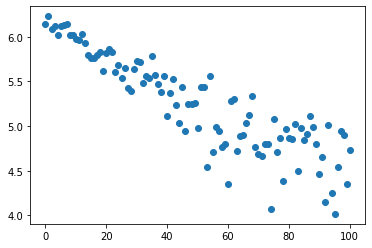

Iteration:   1%|█▎                                                                                                         | 200/16493 [03:23<3:38:34,  1.24it/s]

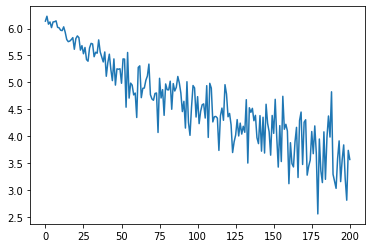

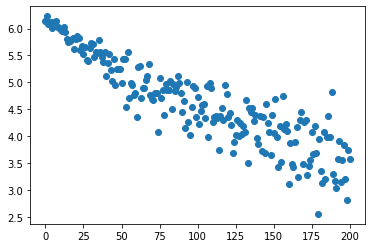

Iteration:   2%|█▉                                                                                                         | 300/16493 [04:52<3:37:19,  1.24it/s]

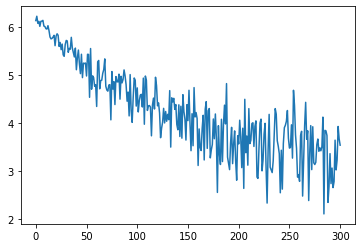

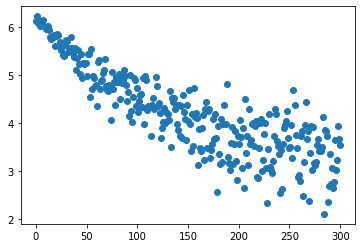

Iteration:   2%|██▌                                                                                                        | 400/16493 [06:17<4:50:10,  1.08s/it]

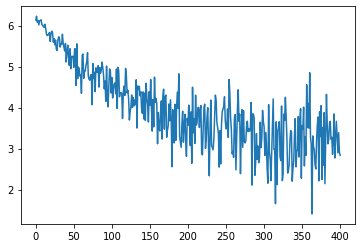

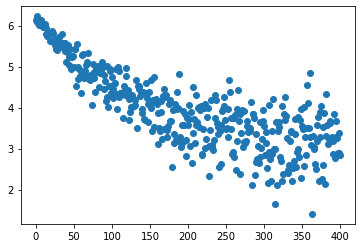

Iteration:   3%|███▏                                                                                                       | 500/16493 [07:42<4:33:38,  1.03s/it]

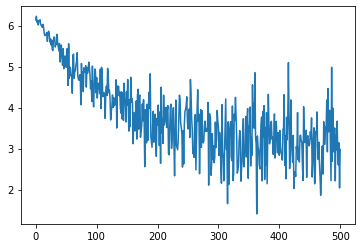

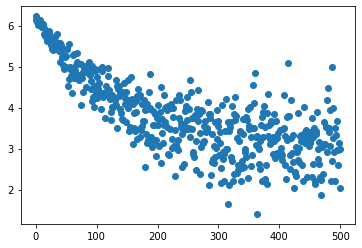

Iteration:   4%|███▉                                                                                                       | 600/16493 [09:08<3:48:17,  1.16it/s]

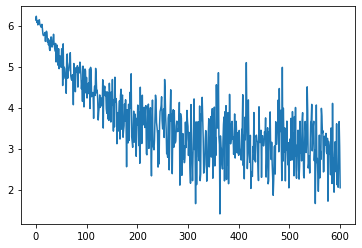

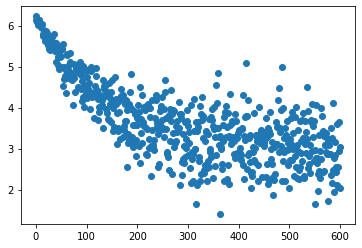

Iteration:   4%|████▌                                                                                                      | 700/16493 [10:34<3:30:48,  1.25it/s]

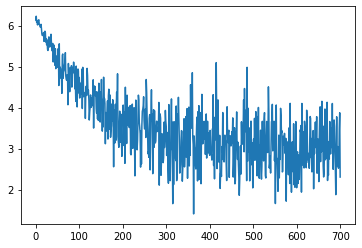

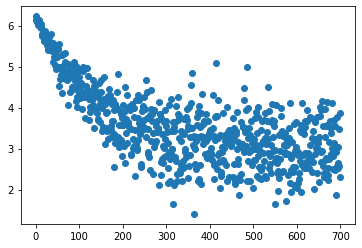

Iteration:   5%|█████▏                                                                                                     | 800/16493 [12:00<3:35:57,  1.21it/s]

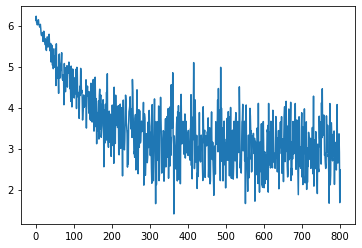

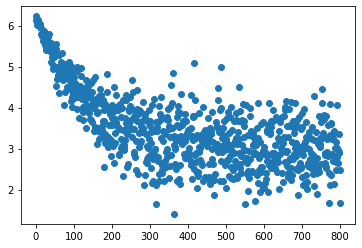

Iteration:   5%|█████▊                                                                                                     | 900/16493 [13:25<4:30:56,  1.04s/it]

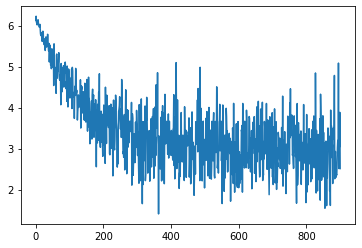

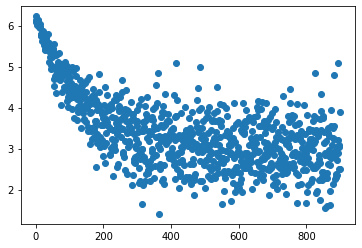

Iteration:   6%|██████▍                                                                                                   | 1000/16493 [14:47<3:23:08,  1.27it/s]

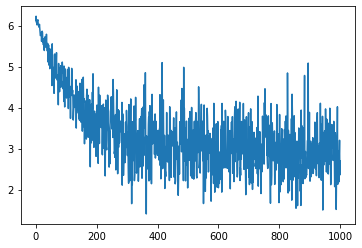

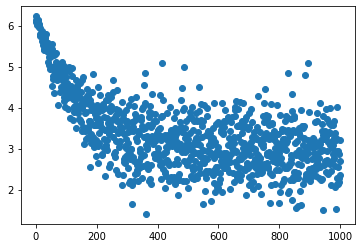

Iteration:   7%|███████                                                                                                   | 1100/16493 [16:14<4:06:48,  1.04it/s]

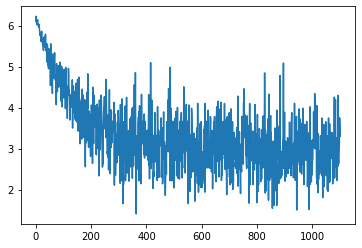

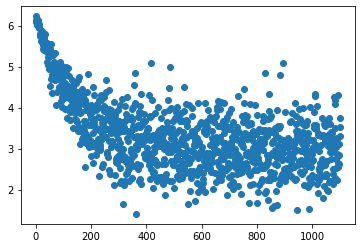

Iteration:   7%|███████▋                                                                                                  | 1200/16493 [17:42<3:08:32,  1.35it/s]

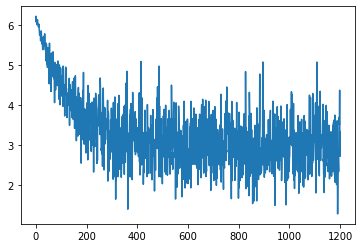

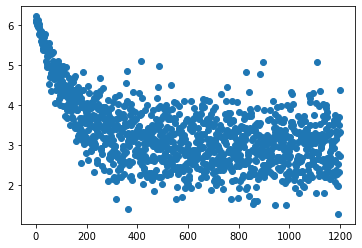

Iteration:   8%|████████▎                                                                                                 | 1300/16493 [19:06<3:18:05,  1.28it/s]

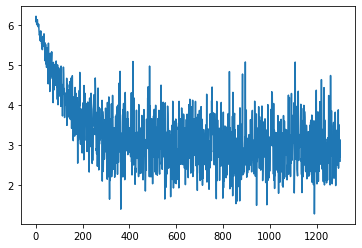

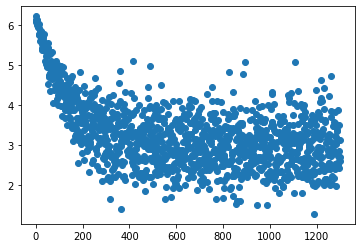

Iteration:   8%|████████▉                                                                                                 | 1400/16493 [20:29<3:13:56,  1.30it/s]

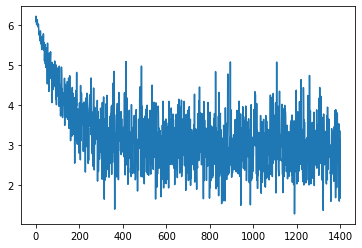

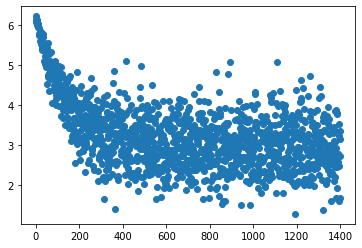

Iteration:   9%|█████████▋                                                                                                | 1500/16493 [21:58<4:22:05,  1.05s/it]

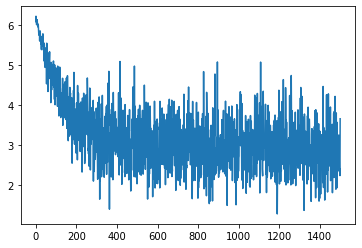

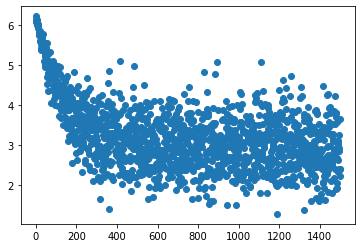

Iteration:  10%|██████████▎                                                                                               | 1600/16493 [23:27<4:27:55,  1.08s/it]

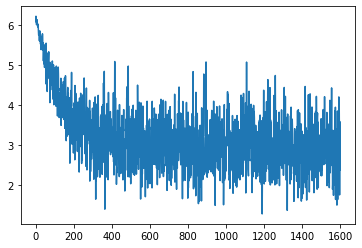

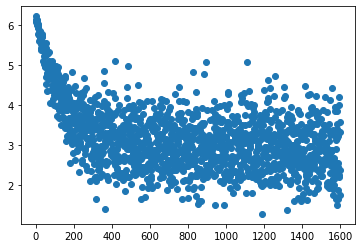

Iteration:  10%|██████████▉                                                                                               | 1700/16493 [24:51<3:17:43,  1.25it/s]

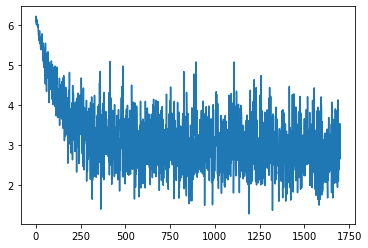

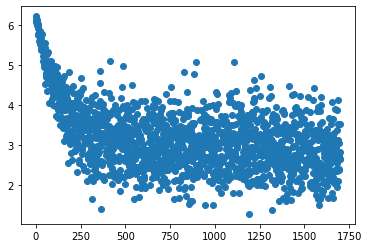

Iteration:  11%|███████████▌                                                                                              | 1800/16493 [26:27<3:42:13,  1.10it/s]

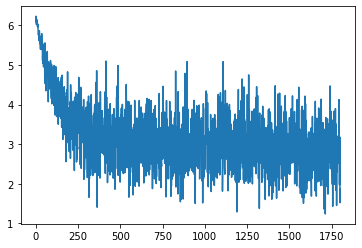

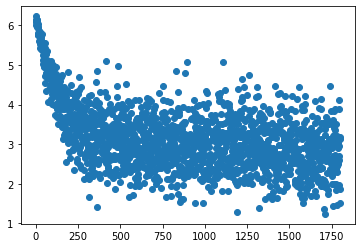

Iteration:  12%|████████████▏                                                                                             | 1900/16493 [27:54<3:08:30,  1.29it/s]

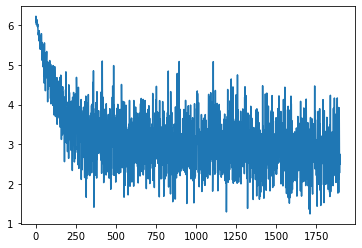

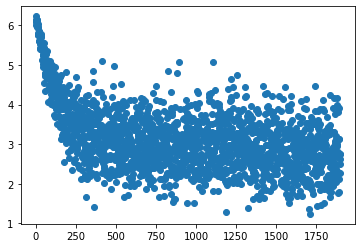

Iteration:  12%|████████████▊                                                                                             | 2000/16493 [29:24<2:56:44,  1.37it/s]

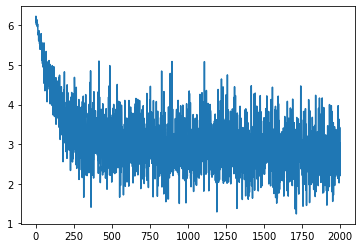

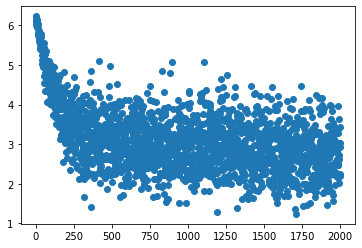

Iteration:  13%|█████████████▍                                                                                            | 2100/16493 [30:46<3:47:21,  1.06it/s]

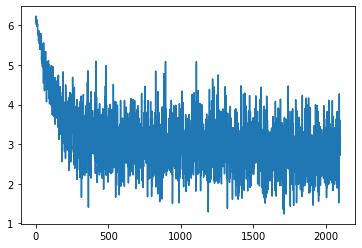

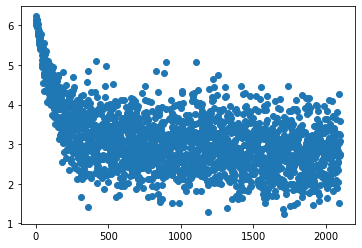

Iteration:  13%|██████████████▏                                                                                           | 2200/16493 [32:11<4:26:25,  1.12s/it]

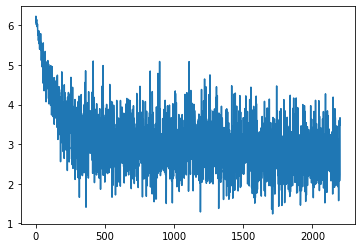

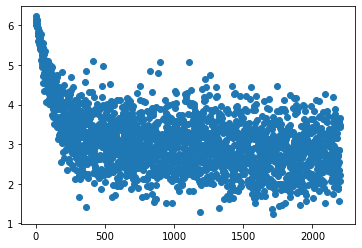

Iteration:  14%|██████████████▊                                                                                           | 2300/16493 [33:35<3:27:01,  1.14it/s]

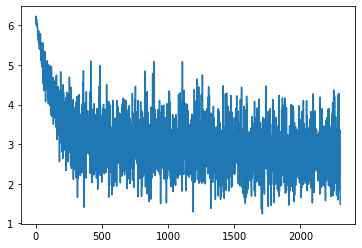

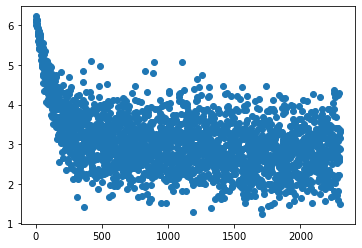

Iteration:  15%|███████████████▍                                                                                          | 2400/16493 [35:13<3:05:45,  1.26it/s]

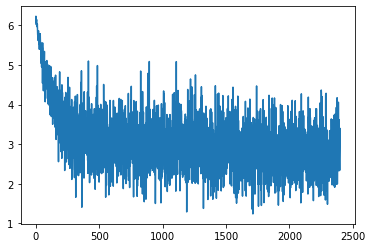

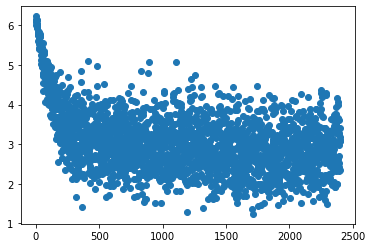

Iteration:  15%|████████████████                                                                                          | 2500/16493 [36:38<4:21:35,  1.12s/it]

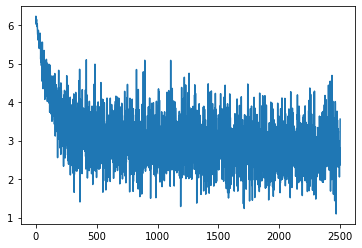

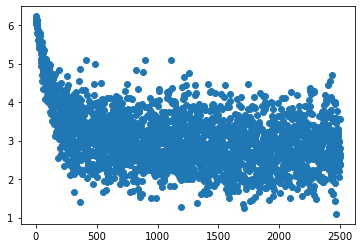

Iteration:  16%|████████████████▋                                                                                         | 2600/16493 [38:06<3:53:57,  1.01s/it]

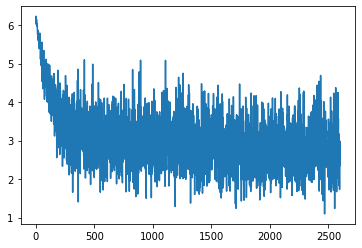

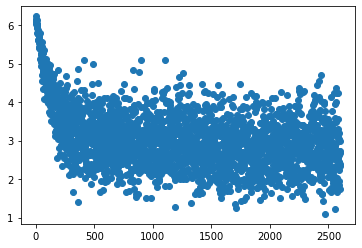

Iteration:  16%|█████████████████▎                                                                                        | 2700/16493 [39:33<3:40:39,  1.04it/s]

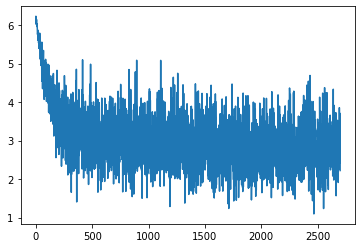

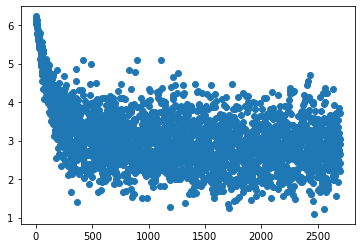

Iteration:  17%|█████████████████▉                                                                                        | 2800/16493 [41:03<2:59:05,  1.27it/s]

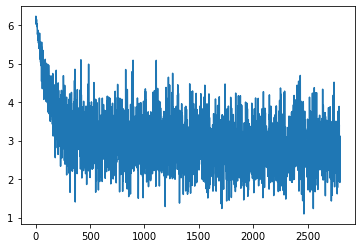

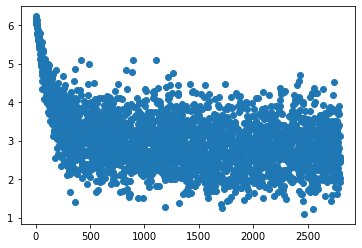

Iteration:  18%|██████████████████▋                                                                                       | 2900/16493 [42:40<2:59:12,  1.26it/s]

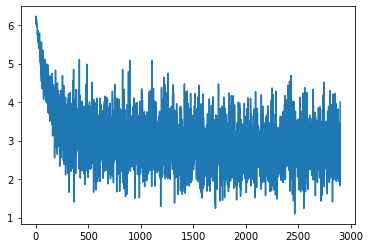

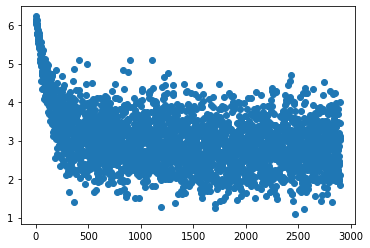

Iteration:  18%|███████████████████▎                                                                                      | 3000/16493 [43:55<2:54:10,  1.29it/s]

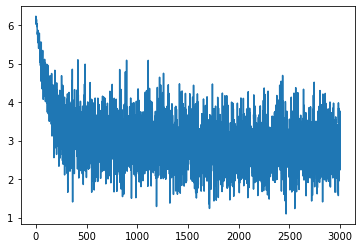

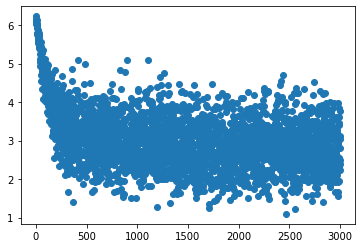

Iteration:  19%|███████████████████▉                                                                                      | 3100/16493 [45:28<3:11:50,  1.16it/s]

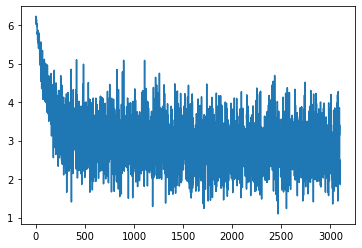

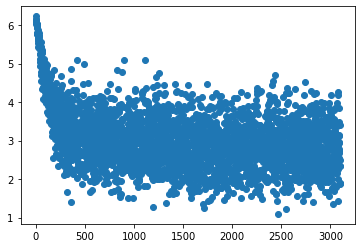

Iteration:  19%|████████████████████▌                                                                                     | 3200/16493 [46:53<2:49:27,  1.31it/s]

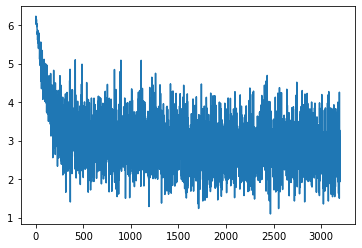

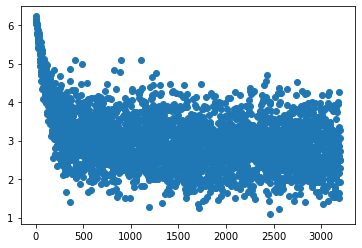

Iteration:  20%|█████████████████████▏                                                                                    | 3300/16493 [48:34<2:54:05,  1.26it/s]

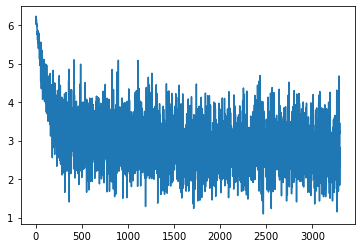

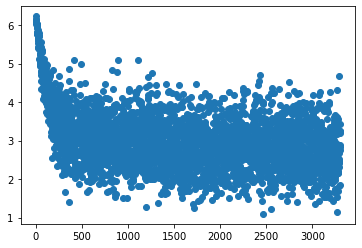

Iteration:  21%|█████████████████████▊                                                                                    | 3400/16493 [49:58<3:08:20,  1.16it/s]

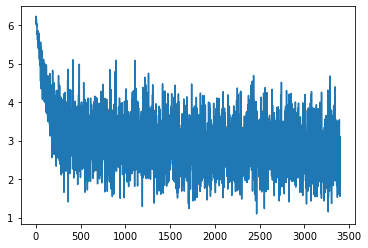

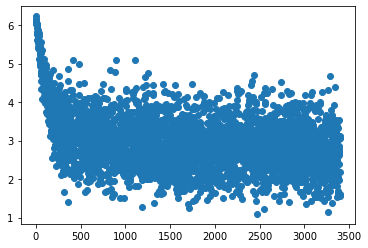

Iteration:  21%|██████████████████████▍                                                                                   | 3500/16493 [51:24<3:28:21,  1.04it/s]

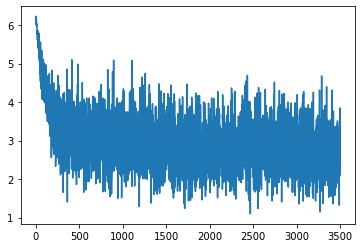

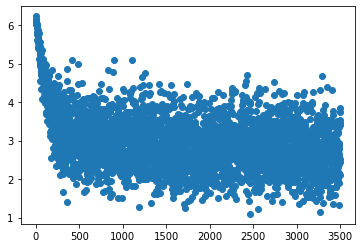

Iteration:  22%|███████████████████████▏                                                                                  | 3600/16493 [52:47<2:54:21,  1.23it/s]

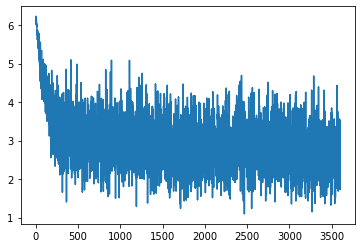

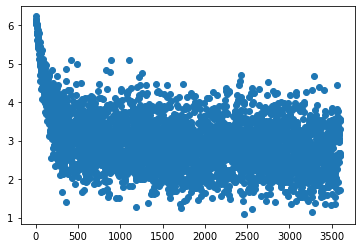

Iteration:  22%|███████████████████████▊                                                                                  | 3700/16493 [54:12<2:50:58,  1.25it/s]

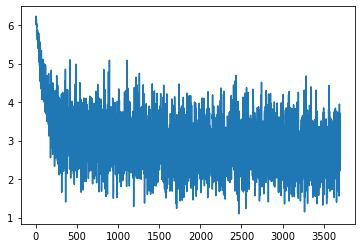

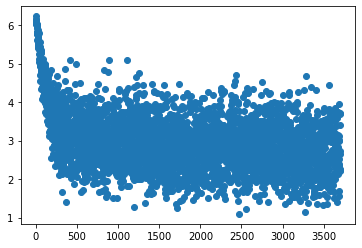

Iteration:  23%|████████████████████████▍                                                                                 | 3800/16493 [55:37<2:49:09,  1.25it/s]

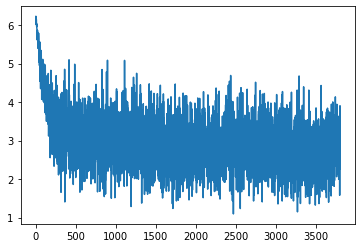

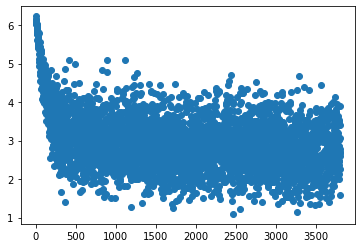

Iteration:  24%|█████████████████████████                                                                                 | 3900/16493 [57:13<3:41:08,  1.05s/it]

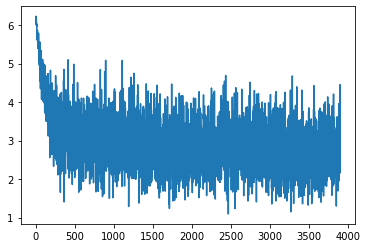

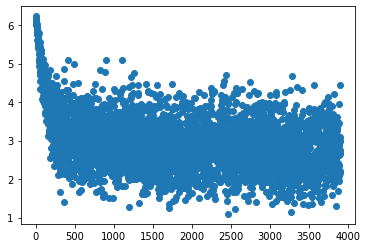

Iteration:  24%|█████████████████████████▋                                                                                | 4000/16493 [58:42<3:51:29,  1.11s/it]

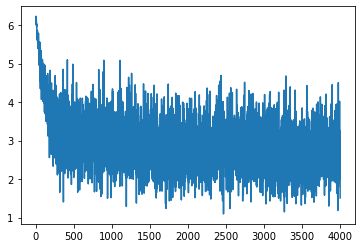

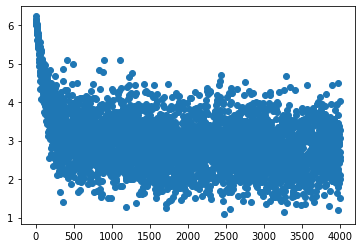

Iteration:  25%|█████████████████████████▊                                                                              | 4100/16493 [1:00:12<3:05:25,  1.11it/s]

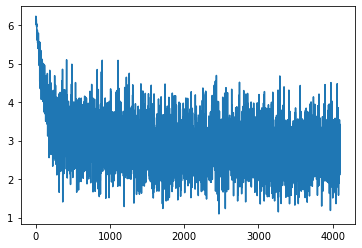

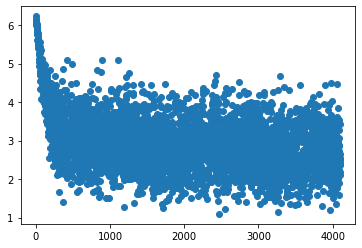

Iteration:  25%|██████████████████████████▍                                                                             | 4200/16493 [1:01:37<2:36:44,  1.31it/s]

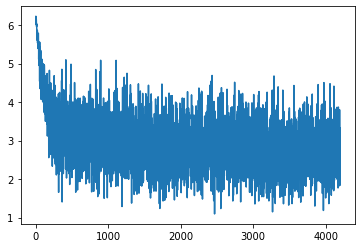

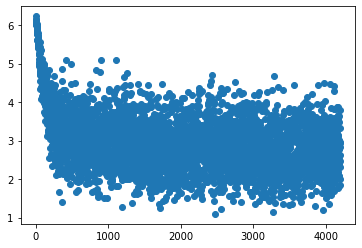

Iteration:  26%|███████████████████████████                                                                             | 4300/16493 [1:03:12<2:52:57,  1.17it/s]

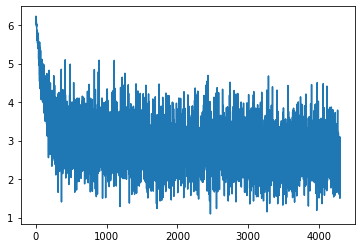

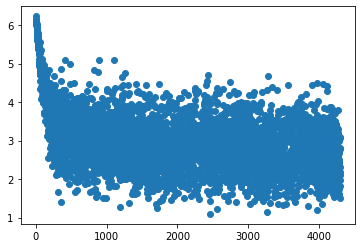

Iteration:  27%|███████████████████████████▋                                                                            | 4400/16493 [1:04:41<3:26:08,  1.02s/it]

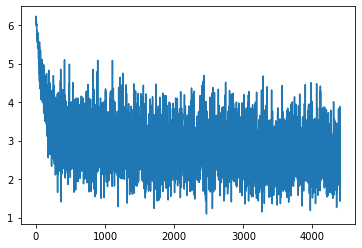

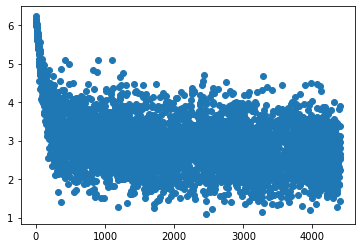

Iteration:  27%|████████████████████████████▍                                                                           | 4500/16493 [1:06:16<3:19:37,  1.00it/s]

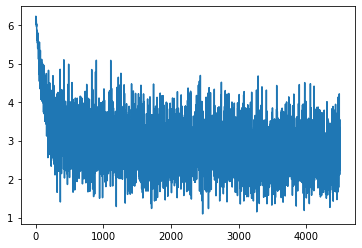

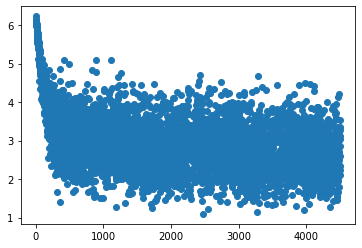

Iteration:  28%|█████████████████████████████                                                                           | 4600/16493 [1:07:47<3:40:08,  1.11s/it]

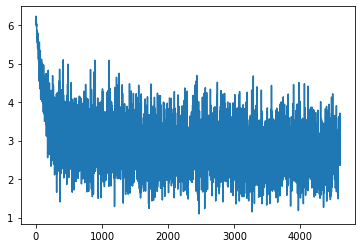

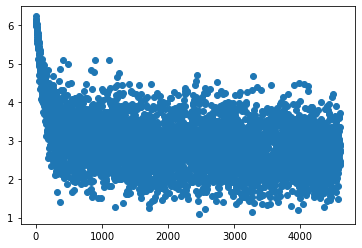

Iteration:  28%|█████████████████████████████▋                                                                          | 4700/16493 [1:09:09<3:40:19,  1.12s/it]

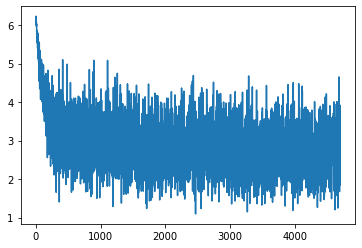

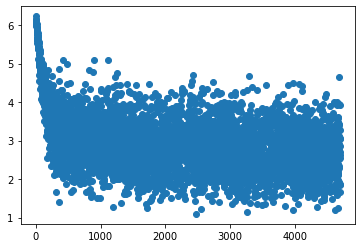

Iteration:  29%|██████████████████████████████▎                                                                         | 4800/16493 [1:10:38<2:35:58,  1.25it/s]

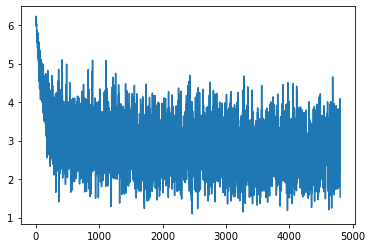

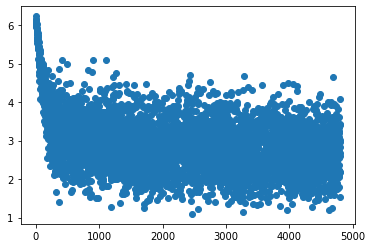

Iteration:  30%|██████████████████████████████▉                                                                         | 4900/16493 [1:12:05<3:33:19,  1.10s/it]

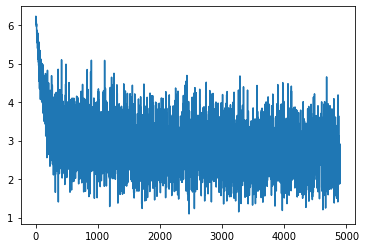

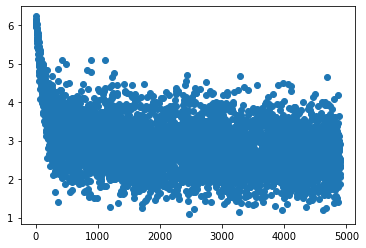

Iteration:  30%|███████████████████████████████▌                                                                        | 5000/16493 [1:13:37<3:19:35,  1.04s/it]

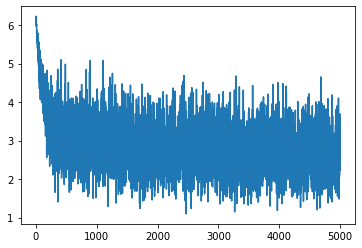

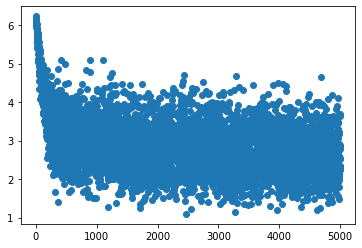

Iteration:  31%|████████████████████████████████▏                                                                       | 5100/16493 [1:15:12<3:13:37,  1.02s/it]

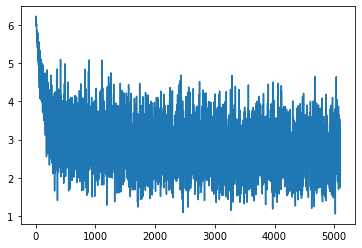

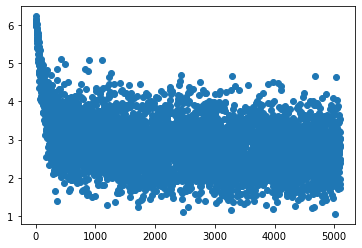

Iteration:  32%|████████████████████████████████▊                                                                       | 5200/16493 [1:16:36<3:05:18,  1.02it/s]

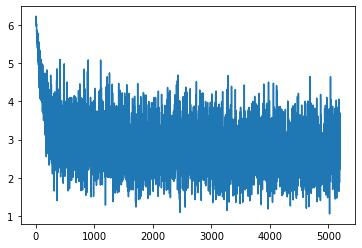

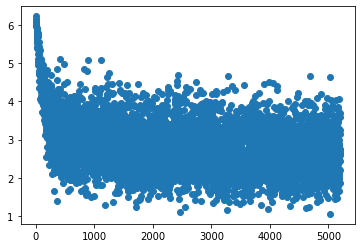

Iteration:  32%|█████████████████████████████████▍                                                                      | 5300/16493 [1:18:13<2:32:35,  1.22it/s]

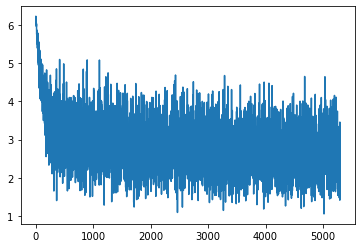

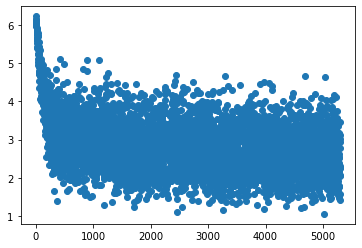

Iteration:  33%|██████████████████████████████████                                                                      | 5400/16493 [1:19:32<2:50:14,  1.09it/s]

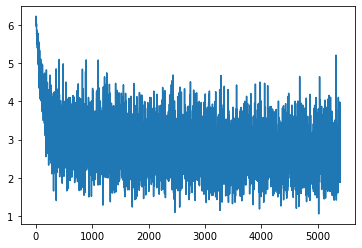

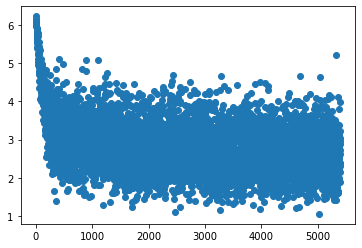

Iteration:  33%|██████████████████████████████████▋                                                                     | 5500/16493 [1:21:00<2:22:56,  1.28it/s]

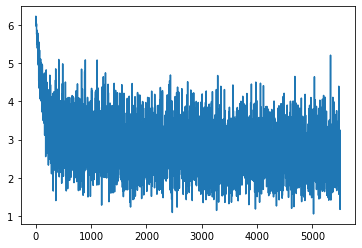

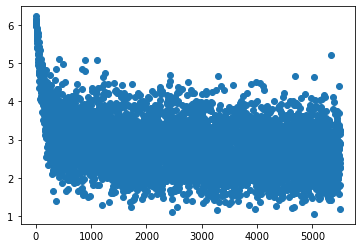

Iteration:  34%|███████████████████████████████████▎                                                                    | 5600/16493 [1:22:29<3:08:48,  1.04s/it]

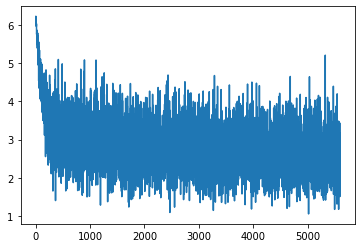

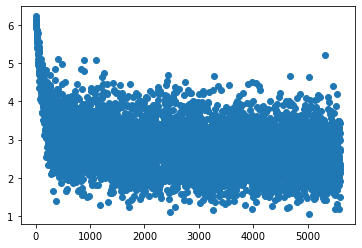

Iteration:  35%|███████████████████████████████████▉                                                                    | 5700/16493 [1:23:57<3:16:15,  1.09s/it]

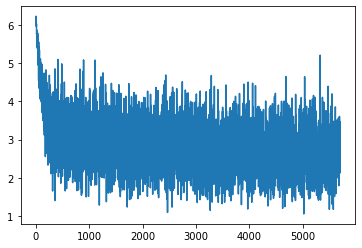

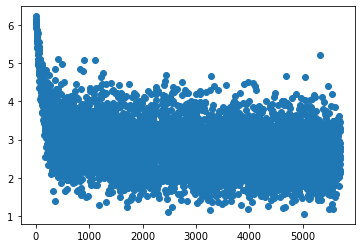

Iteration:  35%|████████████████████████████████████▌                                                                   | 5800/16493 [1:25:19<3:13:00,  1.08s/it]

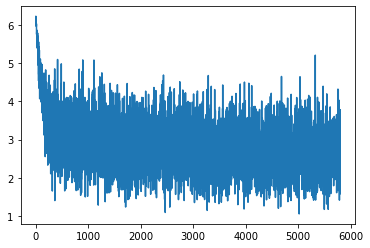

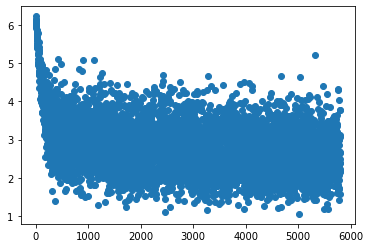

Iteration:  36%|█████████████████████████████████████▏                                                                  | 5900/16493 [1:26:51<2:10:19,  1.35it/s]

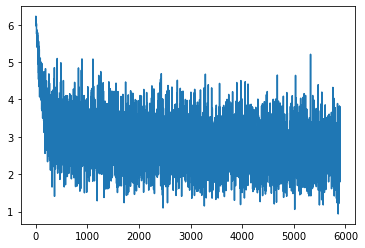

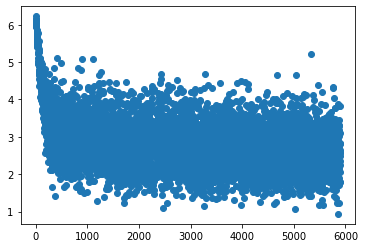

Iteration:  36%|█████████████████████████████████████▊                                                                  | 6000/16493 [1:28:15<2:12:12,  1.32it/s]

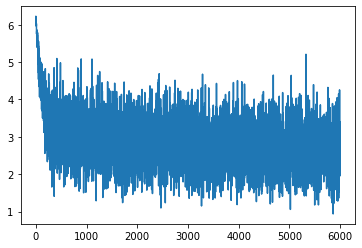

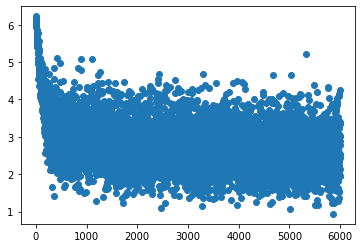

Iteration:  37%|██████████████████████████████████████▍                                                                 | 6100/16493 [1:29:47<2:08:10,  1.35it/s]

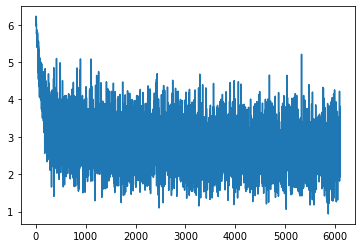

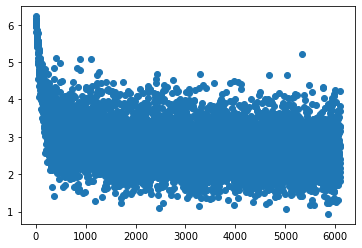

Iteration:  38%|███████████████████████████████████████                                                                 | 6200/16493 [1:31:18<2:37:05,  1.09it/s]

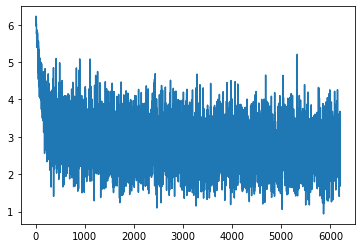

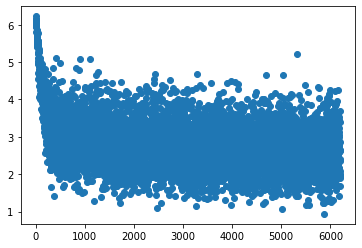

Iteration:  38%|███████████████████████████████████████▋                                                                | 6300/16493 [1:32:41<2:17:38,  1.23it/s]

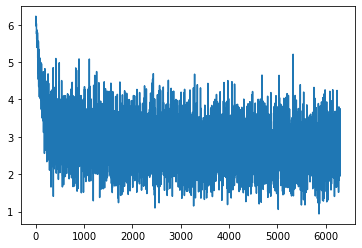

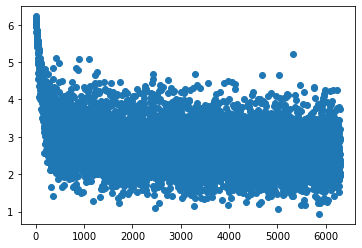

Iteration:  39%|████████████████████████████████████████▎                                                               | 6400/16493 [1:34:12<3:00:10,  1.07s/it]

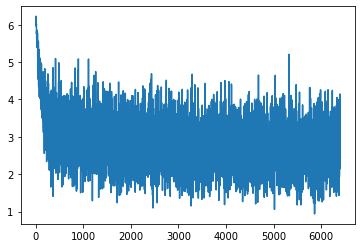

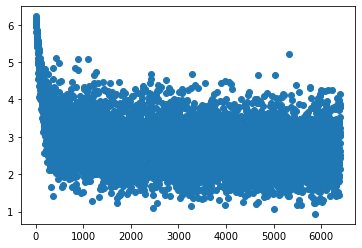

Iteration:  39%|████████████████████████████████████████▉                                                               | 6500/16493 [1:35:44<3:08:33,  1.13s/it]

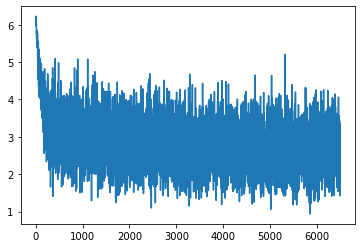

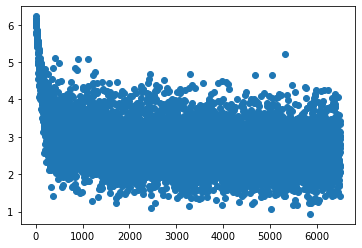

Iteration:  40%|█████████████████████████████████████████▌                                                              | 6600/16493 [1:37:12<3:06:37,  1.13s/it]

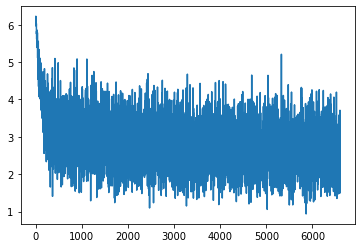

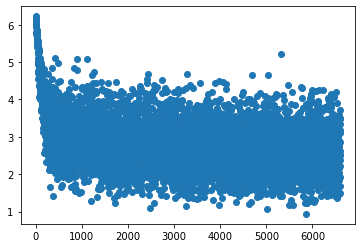

Iteration:  41%|██████████████████████████████████████████▏                                                             | 6700/16493 [1:38:42<2:57:56,  1.09s/it]

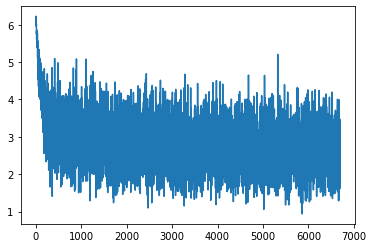

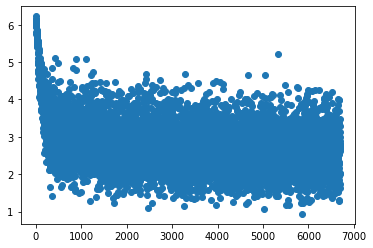

Iteration:  41%|██████████████████████████████████████████▉                                                             | 6800/16493 [1:40:02<2:28:38,  1.09it/s]

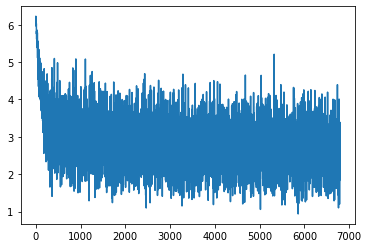

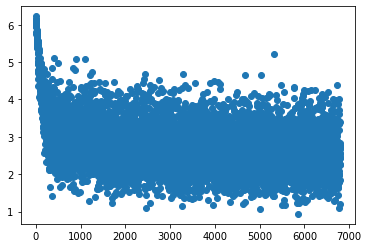

Iteration:  42%|███████████████████████████████████████████▌                                                            | 6900/16493 [1:41:35<2:05:56,  1.27it/s]

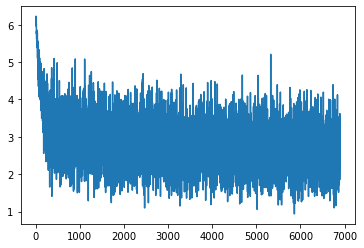

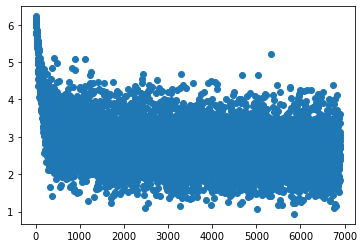

Iteration:  42%|████████████████████████████████████████████▏                                                           | 7000/16493 [1:42:59<2:00:27,  1.31it/s]

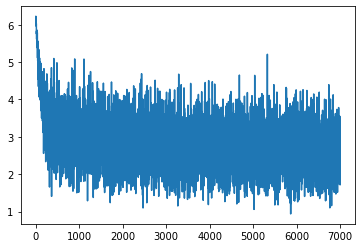

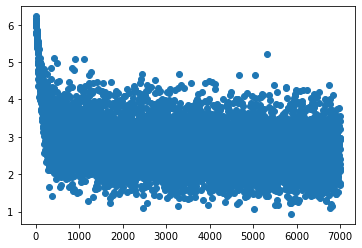

Iteration:  43%|████████████████████████████████████████████▊                                                           | 7100/16493 [1:44:34<2:29:28,  1.05it/s]

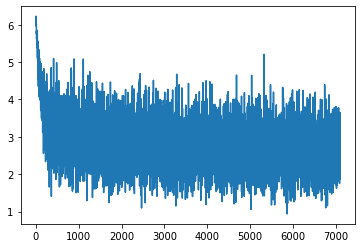

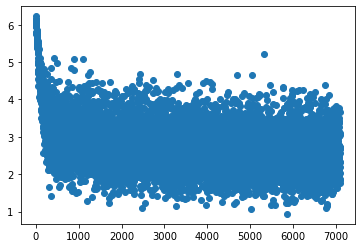

Iteration:  44%|█████████████████████████████████████████████▍                                                          | 7200/16493 [1:46:02<2:01:22,  1.28it/s]

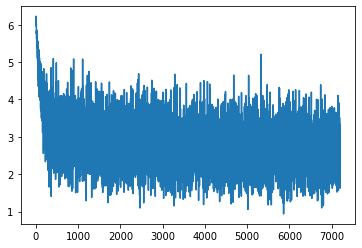

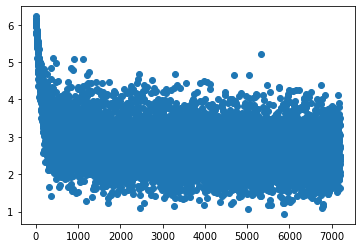

Iteration:  44%|██████████████████████████████████████████████                                                          | 7300/16493 [1:47:30<2:51:26,  1.12s/it]

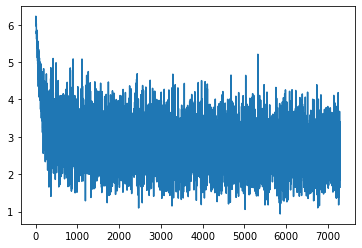

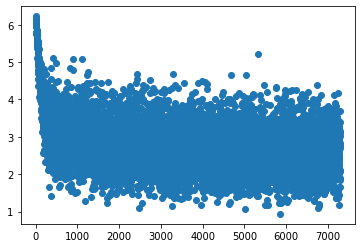

Iteration:  45%|██████████████████████████████████████████████▋                                                         | 7400/16493 [1:48:55<2:50:24,  1.12s/it]

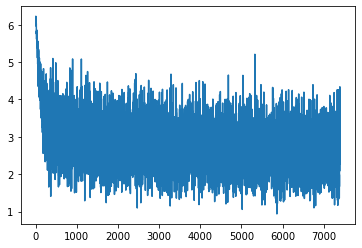

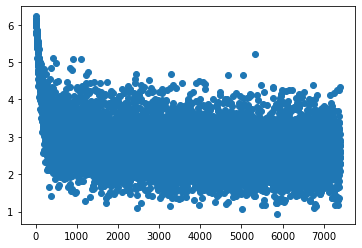

Iteration:  45%|███████████████████████████████████████████████▎                                                        | 7500/16493 [1:50:30<2:09:24,  1.16it/s]

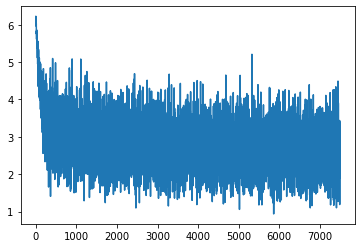

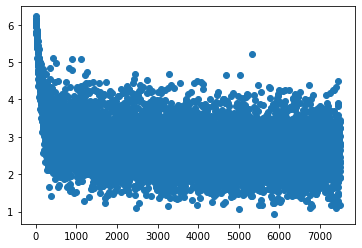

Iteration:  46%|███████████████████████████████████████████████▉                                                        | 7600/16493 [1:51:56<1:53:48,  1.30it/s]

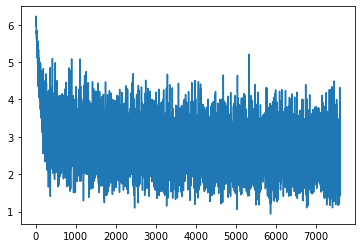

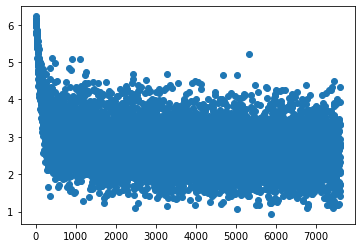

Iteration:  47%|████████████████████████████████████████████████▌                                                       | 7700/16493 [1:53:25<1:59:14,  1.23it/s]

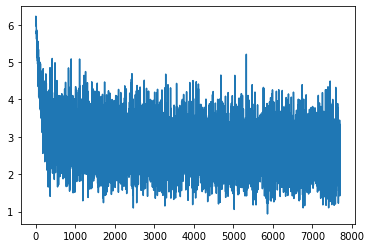

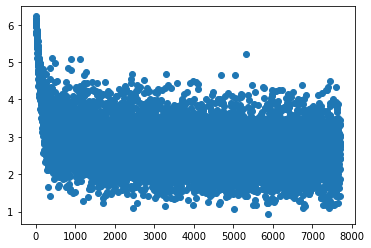

Iteration:  47%|█████████████████████████████████████████████████▏                                                      | 7800/16493 [1:54:51<1:59:49,  1.21it/s]

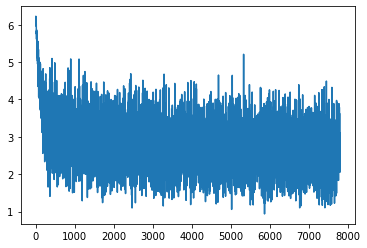

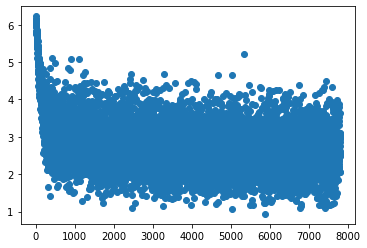

Iteration:  48%|█████████████████████████████████████████████████▊                                                      | 7900/16493 [1:56:16<1:49:23,  1.31it/s]

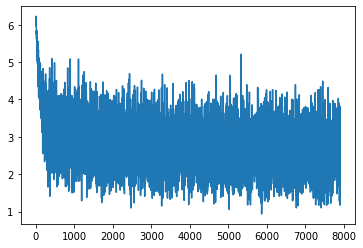

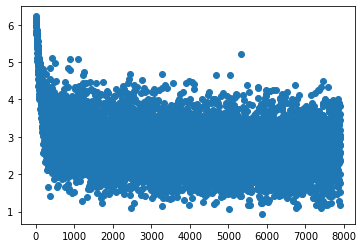

Iteration:  49%|██████████████████████████████████████████████████▍                                                     | 8000/16493 [1:57:46<2:38:36,  1.12s/it]

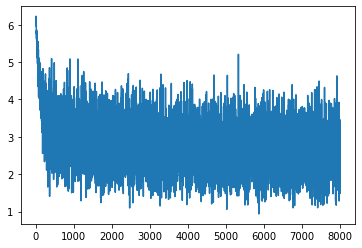

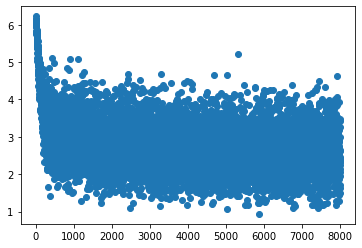

Iteration:  49%|███████████████████████████████████████████████████                                                     | 8100/16493 [1:59:15<2:01:26,  1.15it/s]

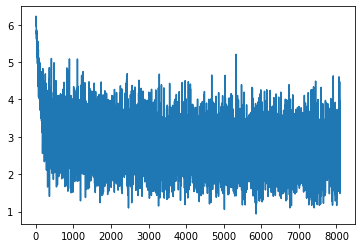

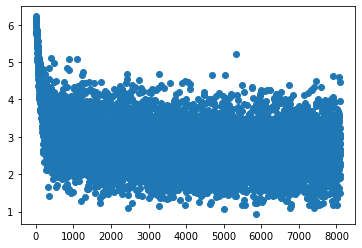

Iteration:  50%|███████████████████████████████████████████████████▋                                                    | 8200/16493 [2:00:43<1:58:23,  1.17it/s]

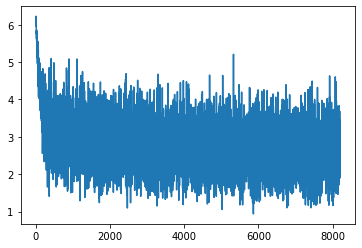

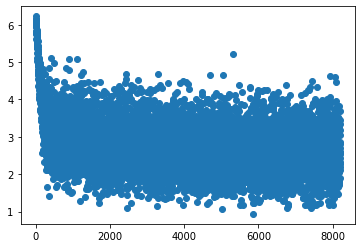

Iteration:  50%|████████████████████████████████████████████████████▎                                                   | 8300/16493 [2:02:12<2:04:51,  1.09it/s]

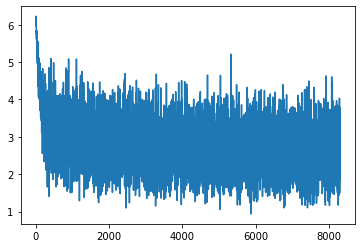

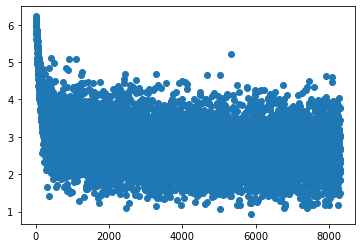

Iteration:  51%|████████████████████████████████████████████████████▉                                                   | 8400/16493 [2:03:39<2:14:14,  1.00it/s]

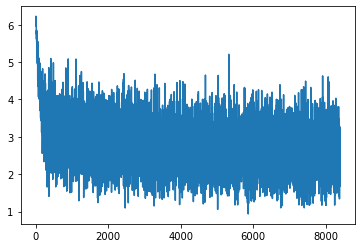

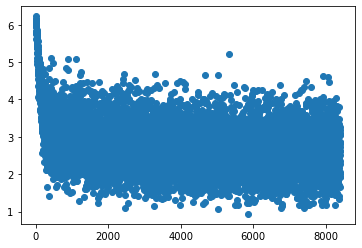

Iteration:  52%|█████████████████████████████████████████████████████▌                                                  | 8500/16493 [2:05:05<1:47:29,  1.24it/s]

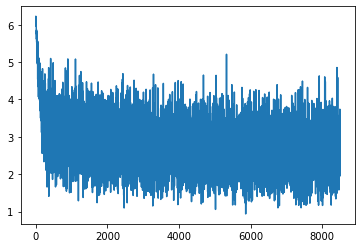

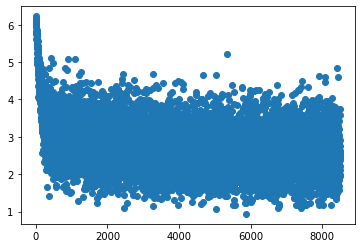

Iteration:  52%|██████████████████████████████████████████████████████▏                                                 | 8600/16493 [2:06:35<1:44:53,  1.25it/s]

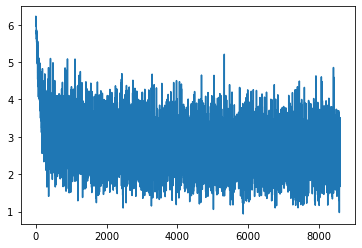

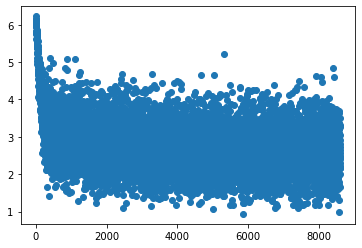

Iteration:  53%|██████████████████████████████████████████████████████▊                                                 | 8700/16493 [2:08:01<1:41:03,  1.29it/s]

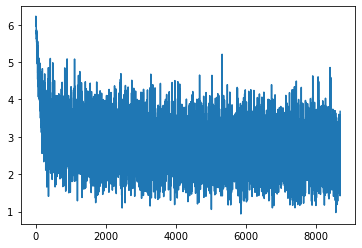

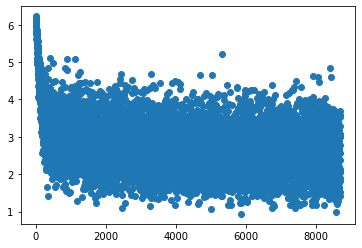

Iteration:  53%|███████████████████████████████████████████████████████▍                                                | 8800/16493 [2:09:33<1:48:23,  1.18it/s]

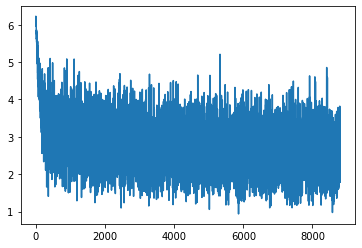

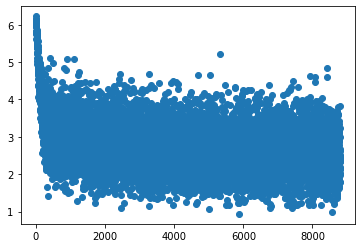

Iteration:  54%|████████████████████████████████████████████████████████                                                | 8900/16493 [2:11:00<2:09:31,  1.02s/it]

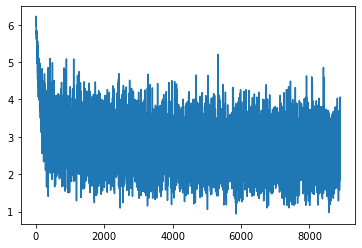

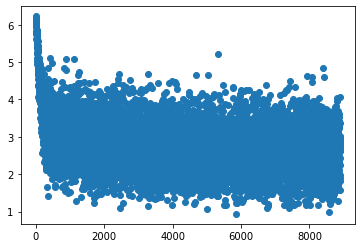

Iteration:  55%|████████████████████████████████████████████████████████▊                                               | 9000/16493 [2:12:27<2:08:09,  1.03s/it]

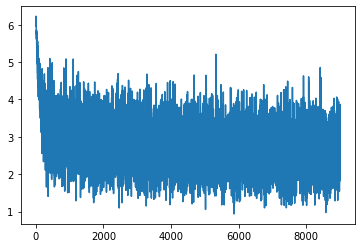

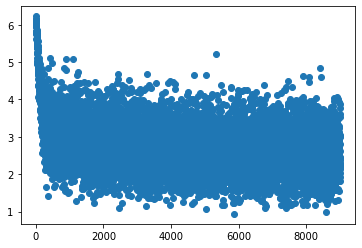

Iteration:  55%|█████████████████████████████████████████████████████████▍                                              | 9100/16493 [2:14:04<1:34:47,  1.30it/s]

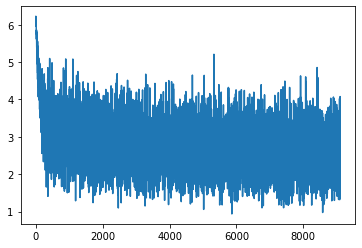

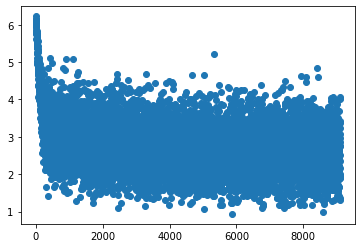

Iteration:  56%|██████████████████████████████████████████████████████████                                              | 9200/16493 [2:15:32<1:59:01,  1.02it/s]

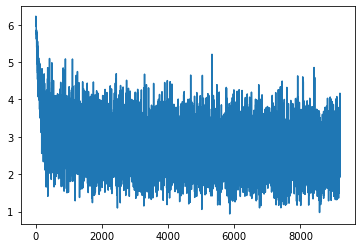

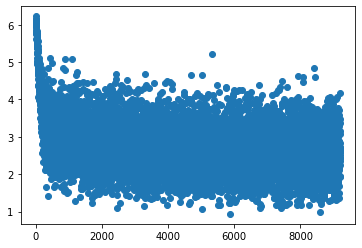

Iteration:  56%|██████████████████████████████████████████████████████████▋                                             | 9300/16493 [2:16:59<2:04:06,  1.04s/it]

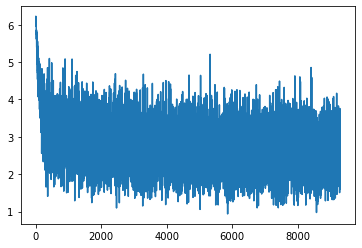

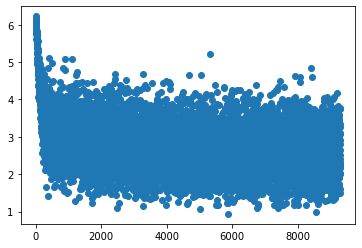

Iteration:  57%|███████████████████████████████████████████████████████████▎                                            | 9400/16493 [2:18:30<1:33:45,  1.26it/s]

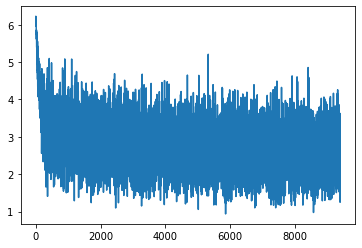

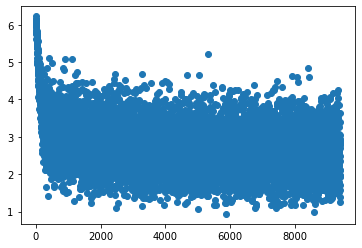

Iteration:  58%|███████████████████████████████████████████████████████████▉                                            | 9500/16493 [2:19:56<1:32:57,  1.25it/s]

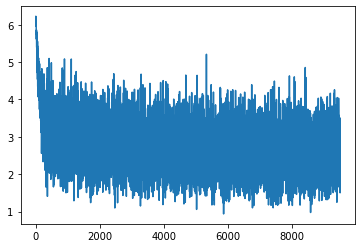

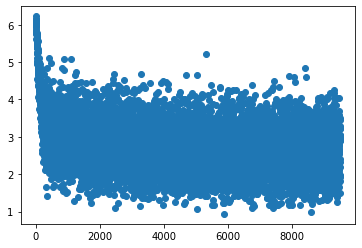

Iteration:  58%|████████████████████████████████████████████████████████████▌                                           | 9600/16493 [2:21:27<1:26:48,  1.32it/s]

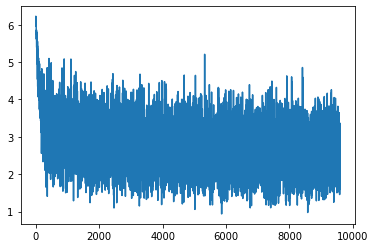

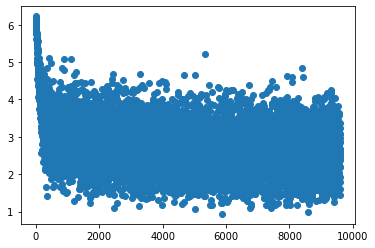

Iteration:  59%|█████████████████████████████████████████████████████████████▏                                          | 9700/16493 [2:22:58<1:44:18,  1.09it/s]

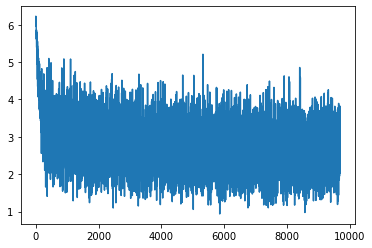

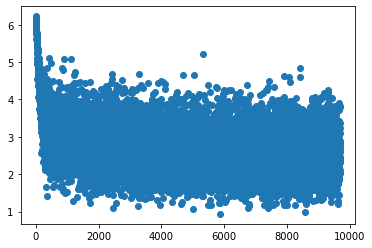

Iteration:  59%|█████████████████████████████████████████████████████████████▊                                          | 9800/16493 [2:24:24<1:28:44,  1.26it/s]

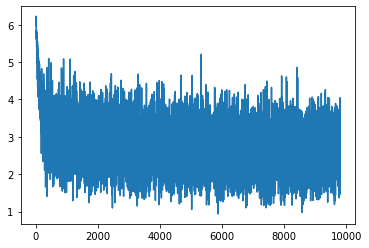

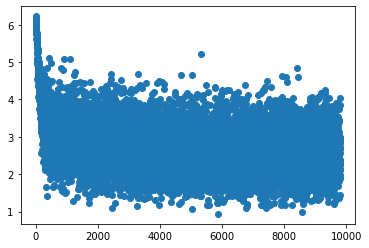

Iteration:  60%|██████████████████████████████████████████████████████████████▍                                         | 9900/16493 [2:25:50<2:02:17,  1.11s/it]

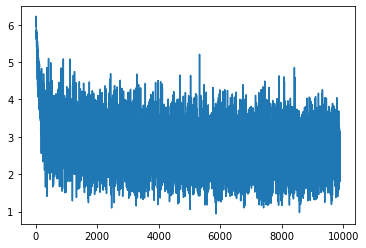

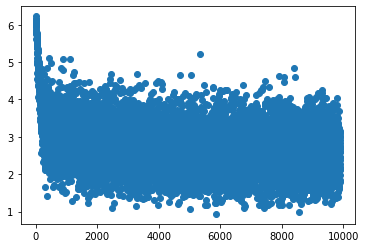

Iteration:  61%|██████████████████████████████████████████████████████████████▍                                        | 10000/16493 [2:27:23<2:42:43,  1.50s/it]

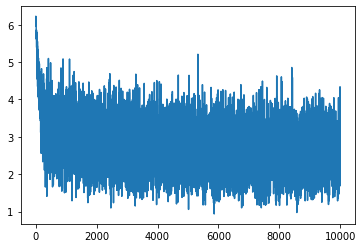

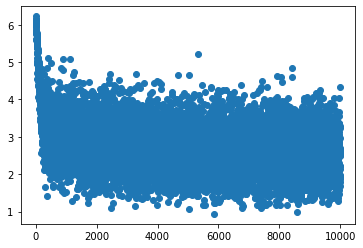

Iteration:  61%|███████████████████████████████████████████████████████████████                                        | 10100/16493 [2:28:46<1:20:02,  1.33it/s]

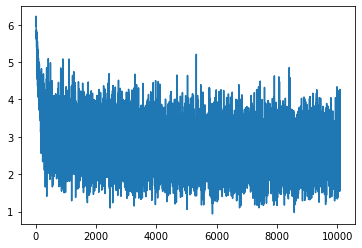

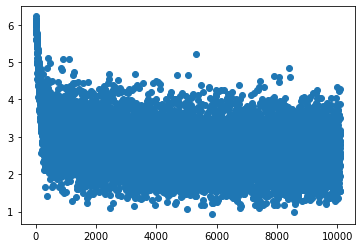

Iteration:  62%|███████████████████████████████████████████████████████████████▋                                       | 10200/16493 [2:30:20<1:53:47,  1.08s/it]

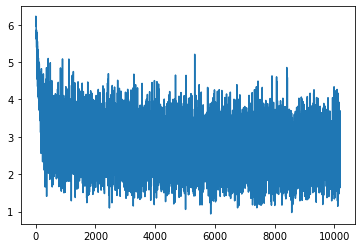

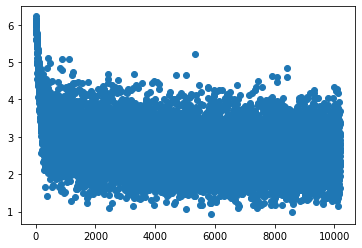

Iteration:  62%|████████████████████████████████████████████████████████████████▎                                      | 10300/16493 [2:31:45<1:24:32,  1.22it/s]

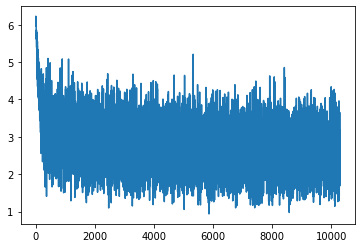

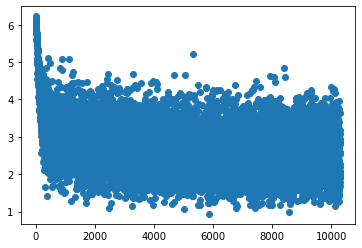

Iteration:  63%|████████████████████████████████████████████████████████████████▉                                      | 10400/16493 [2:33:13<1:43:51,  1.02s/it]

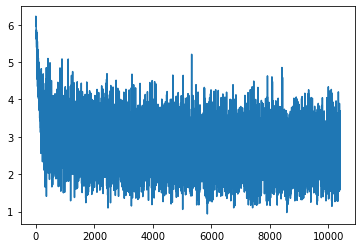

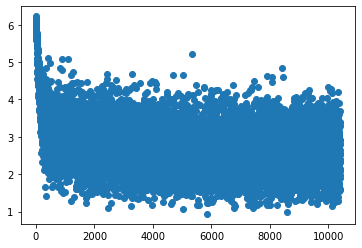

Iteration:  64%|█████████████████████████████████████████████████████████████████▌                                     | 10500/16493 [2:34:40<1:17:30,  1.29it/s]

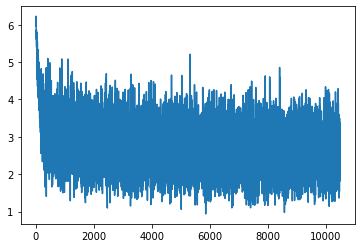

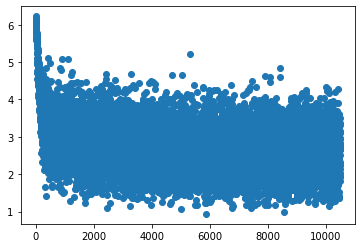

Iteration:  64%|██████████████████████████████████████████████████████████████████▏                                    | 10600/16493 [2:36:04<1:16:22,  1.29it/s]

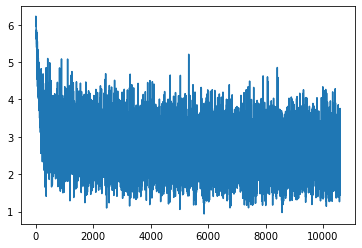

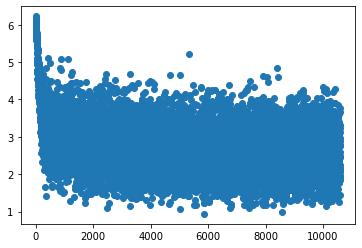

Iteration:  65%|██████████████████████████████████████████████████████████████████▊                                    | 10700/16493 [2:37:27<1:24:57,  1.14it/s]

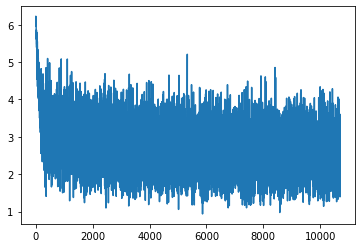

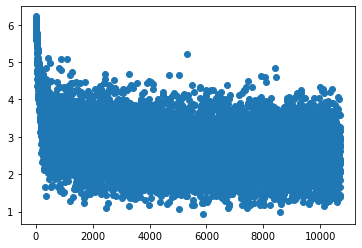

Iteration:  65%|███████████████████████████████████████████████████████████████████▍                                   | 10800/16493 [2:39:01<1:35:27,  1.01s/it]

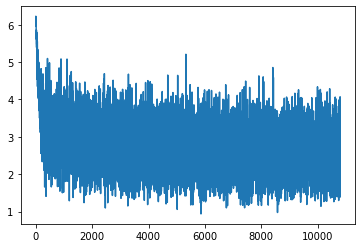

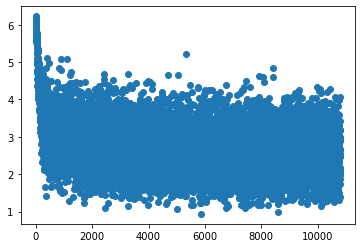

Iteration:  66%|████████████████████████████████████████████████████████████████████                                   | 10900/16493 [2:40:28<1:11:54,  1.30it/s]

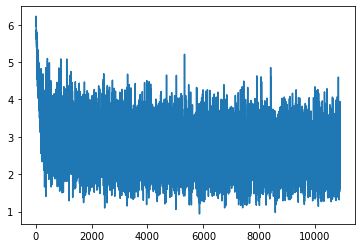

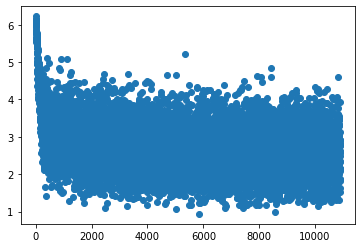

Iteration:  67%|████████████████████████████████████████████████████████████████████▋                                  | 11000/16493 [2:41:55<1:12:02,  1.27it/s]

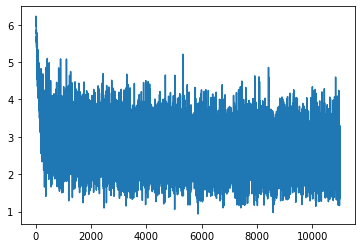

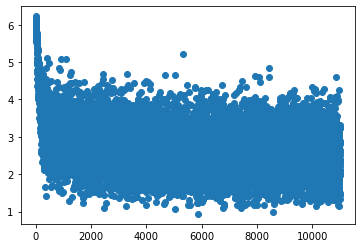

Iteration:  67%|█████████████████████████████████████████████████████████████████████▎                                 | 11100/16493 [2:43:19<1:08:25,  1.31it/s]

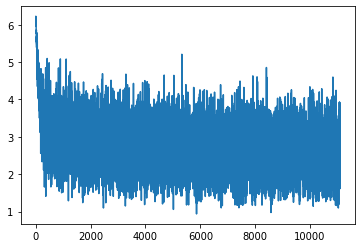

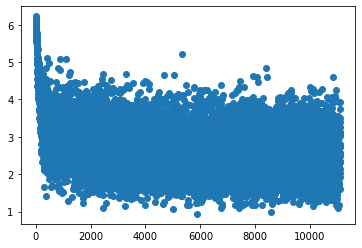

Iteration:  68%|█████████████████████████████████████████████████████████████████████▉                                 | 11200/16493 [2:44:50<1:07:02,  1.32it/s]

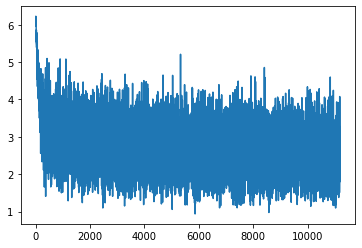

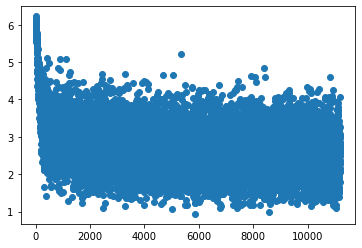

Iteration:  69%|██████████████████████████████████████████████████████████████████████▌                                | 11300/16493 [2:46:24<1:24:36,  1.02it/s]

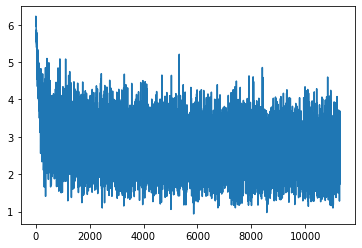

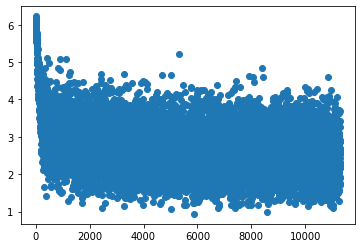

Iteration:  69%|███████████████████████████████████████████████████████████████████████▏                               | 11400/16493 [2:47:50<1:09:00,  1.23it/s]

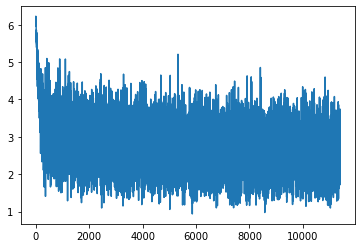

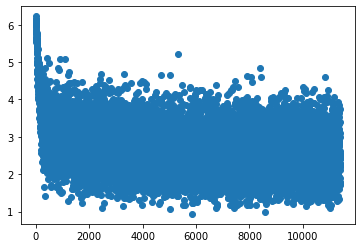

Iteration:  70%|███████████████████████████████████████████████████████████████████████▊                               | 11500/16493 [2:49:24<1:28:51,  1.07s/it]

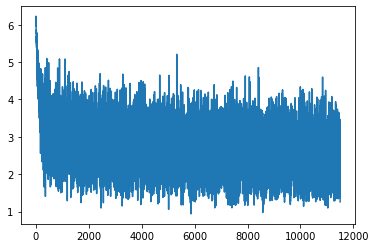

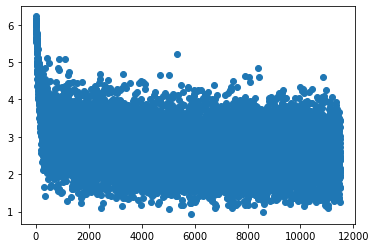

Iteration:  70%|████████████████████████████████████████████████████████████████████████▍                              | 11600/16493 [2:50:50<1:32:25,  1.13s/it]

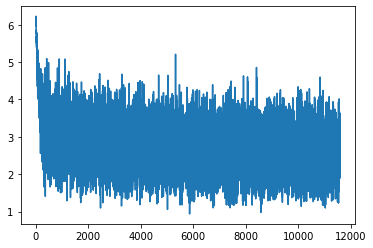

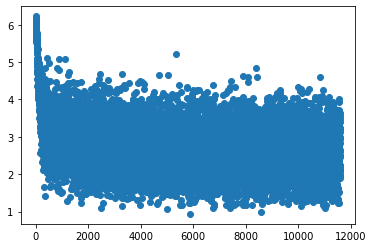

Iteration:  71%|█████████████████████████████████████████████████████████████████████████                              | 11700/16493 [2:52:22<1:03:20,  1.26it/s]

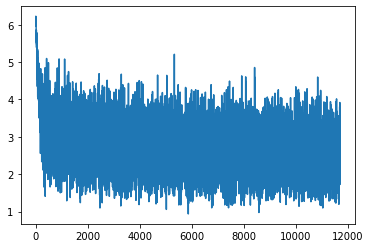

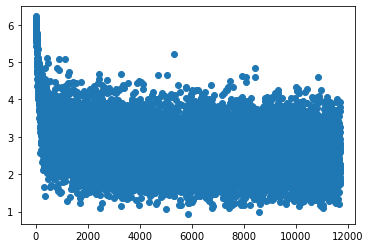

Iteration:  72%|█████████████████████████████████████████████████████████████████████████▋                             | 11800/16493 [2:53:46<1:22:41,  1.06s/it]

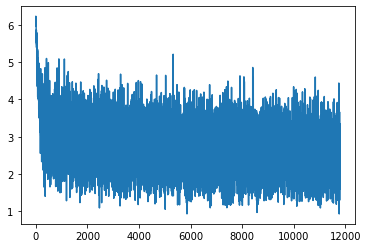

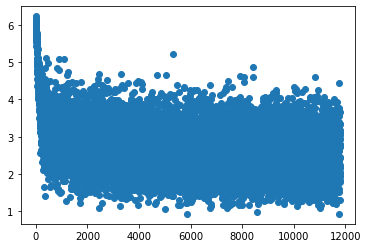

Iteration:  72%|██████████████████████████████████████████████████████████████████████████▎                            | 11900/16493 [2:55:20<1:16:10,  1.00it/s]

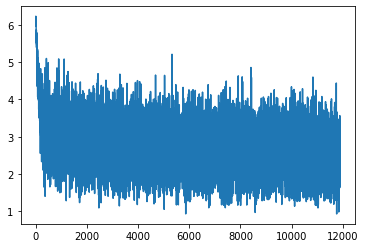

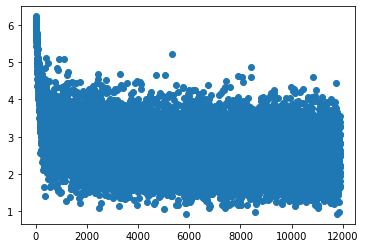

Iteration:  73%|████████████████████████████████████████████████████████████████████████████▍                            | 12000/16493 [2:56:52<57:07,  1.31it/s]

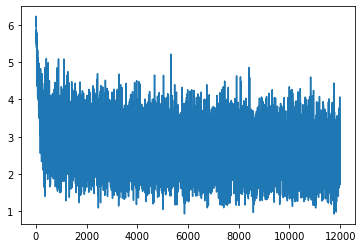

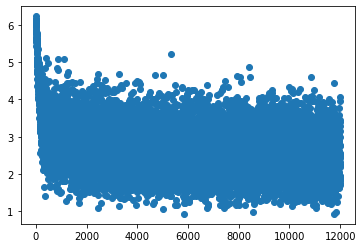

Iteration:  73%|█████████████████████████████████████████████████████████████████████████████                            | 12100/16493 [2:58:23<58:41,  1.25it/s]

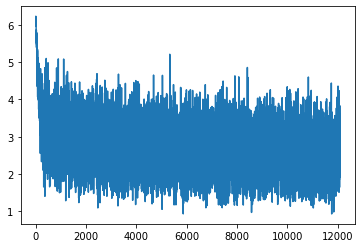

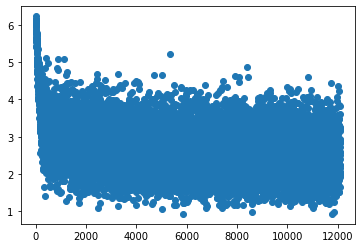

Iteration:  74%|█████████████████████████████████████████████████████████████████████████████▋                           | 12200/16493 [2:59:52<59:08,  1.21it/s]

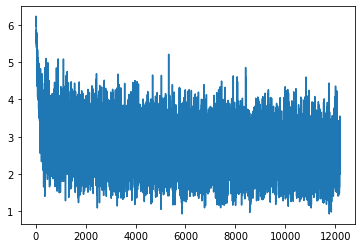

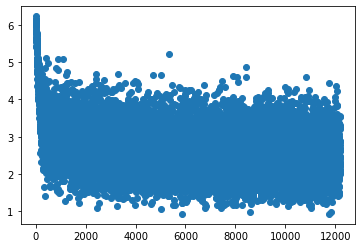

Iteration:  75%|████████████████████████████████████████████████████████████████████████████▊                          | 12300/16493 [3:01:20<1:07:58,  1.03it/s]

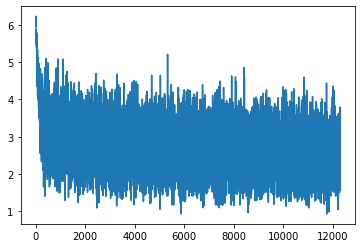

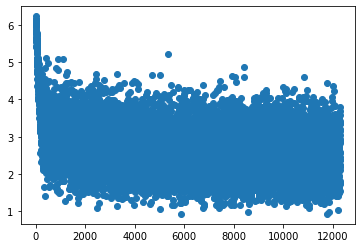

Iteration:  75%|█████████████████████████████████████████████████████████████████████████████▍                         | 12400/16493 [3:02:50<1:13:33,  1.08s/it]

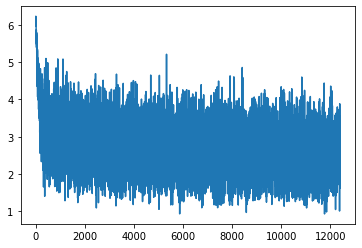

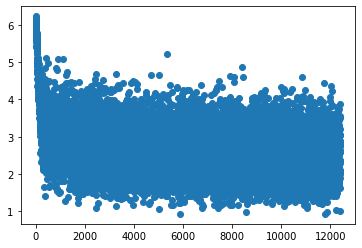

Iteration:  76%|██████████████████████████████████████████████████████████████████████████████                         | 12500/16493 [3:04:22<1:05:26,  1.02it/s]

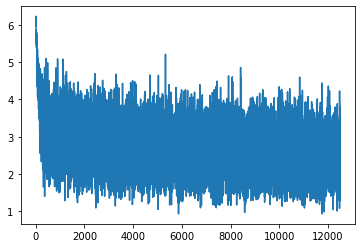

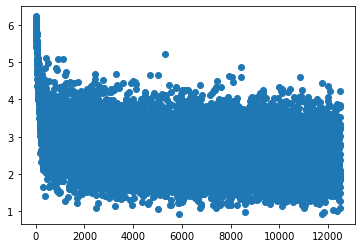

Iteration:  76%|██████████████████████████████████████████████████████████████████████████████▋                        | 12600/16493 [3:05:49<1:00:05,  1.08it/s]

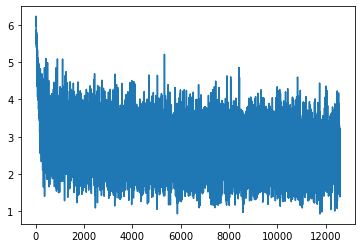

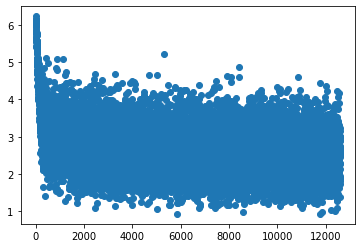

Iteration:  77%|████████████████████████████████████████████████████████████████████████████████▊                        | 12700/16493 [3:07:26<57:02,  1.11it/s]

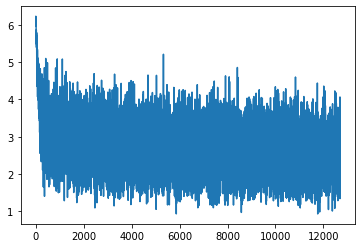

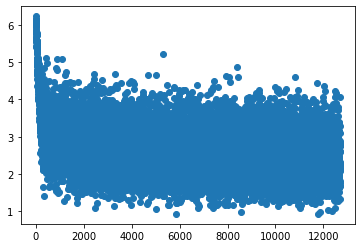

Iteration:  78%|█████████████████████████████████████████████████████████████████████████████████▍                       | 12800/16493 [3:08:51<49:08,  1.25it/s]

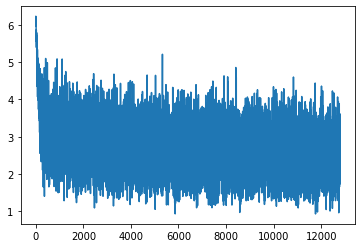

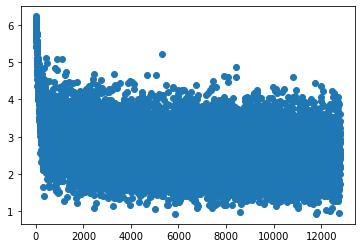

Iteration:  78%|██████████████████████████████████████████████████████████████████████████████████▏                      | 12900/16493 [3:10:14<58:34,  1.02it/s]

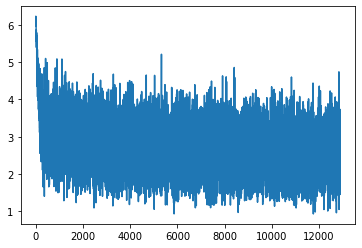

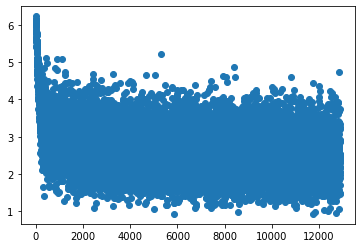

Iteration:  79%|██████████████████████████████████████████████████████████████████████████████████▊                      | 13000/16493 [3:11:40<56:24,  1.03it/s]

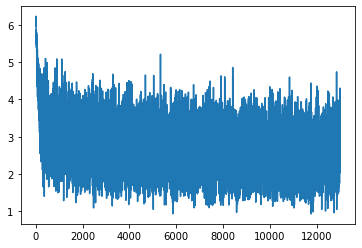

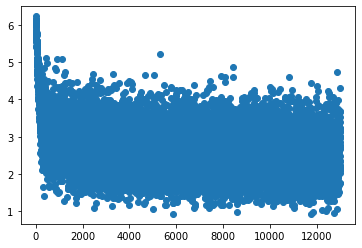

Iteration:  79%|█████████████████████████████████████████████████████████████████████████████████▊                     | 13100/16493 [3:13:11<1:03:49,  1.13s/it]

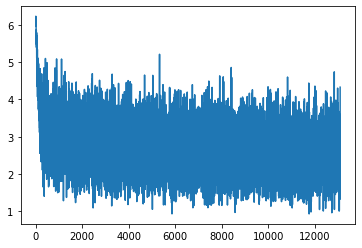

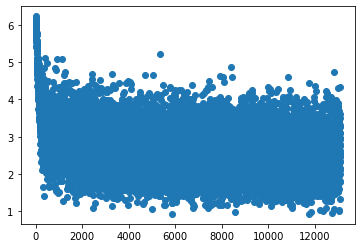

Iteration:  80%|██████████████████████████████████████████████████████████████████████████████████▍                    | 13200/16493 [3:14:37<1:01:44,  1.12s/it]

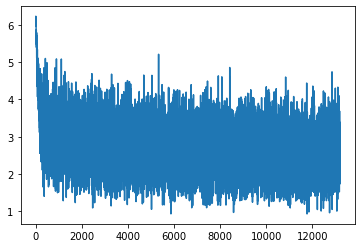

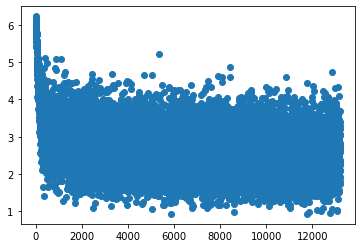

Iteration:  81%|████████████████████████████████████████████████████████████████████████████████████▋                    | 13300/16493 [3:16:09<42:11,  1.26it/s]

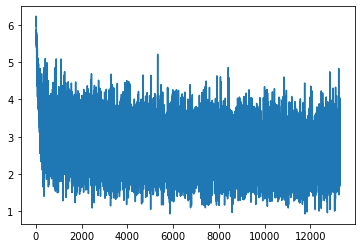

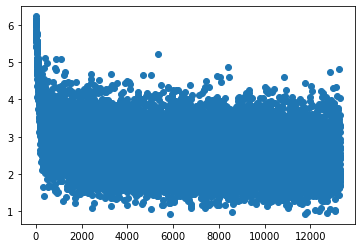

Iteration:  81%|█████████████████████████████████████████████████████████████████████████████████████▎                   | 13400/16493 [3:17:42<54:10,  1.05s/it]

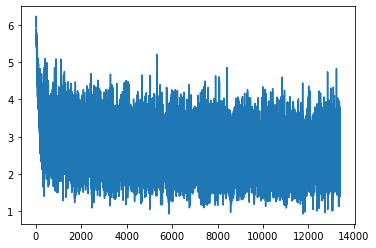

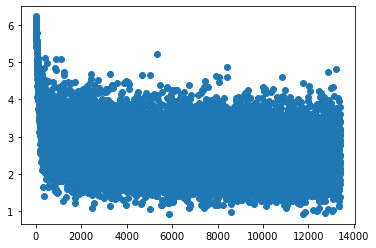

Iteration:  82%|█████████████████████████████████████████████████████████████████████████████████████▉                   | 13500/16493 [3:19:05<50:19,  1.01s/it]

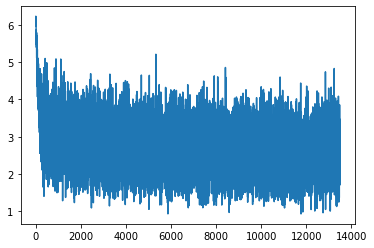

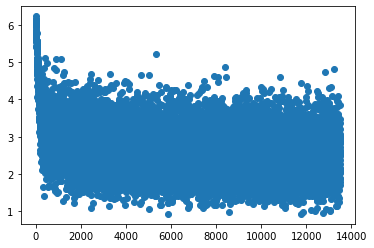

Iteration:  82%|██████████████████████████████████████████████████████████████████████████████████████▌                  | 13600/16493 [3:20:38<35:23,  1.36it/s]

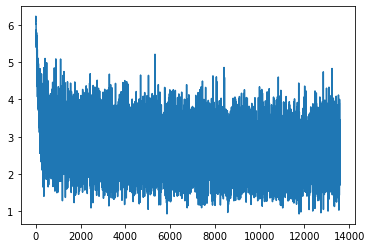

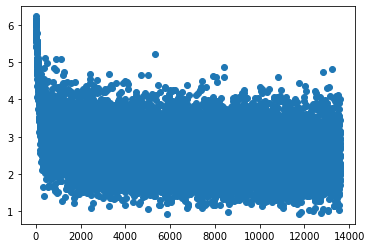

Iteration:  83%|███████████████████████████████████████████████████████████████████████████████████████▏                 | 13700/16493 [3:22:07<35:21,  1.32it/s]

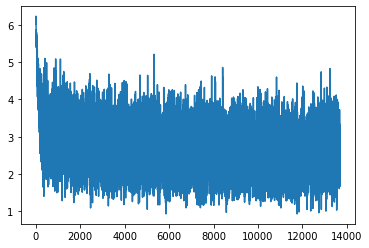

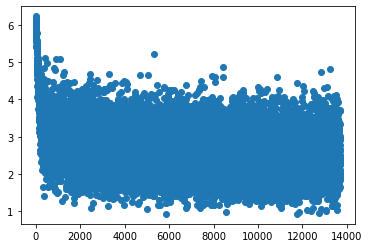

Iteration:  84%|███████████████████████████████████████████████████████████████████████████████████████▊                 | 13800/16493 [3:23:41<33:01,  1.36it/s]

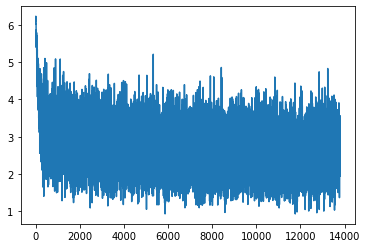

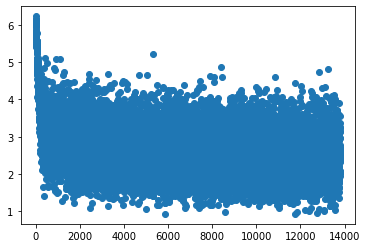

Iteration:  84%|████████████████████████████████████████████████████████████████████████████████████████▍                | 13900/16493 [3:25:05<41:47,  1.03it/s]

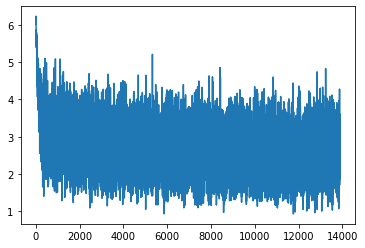

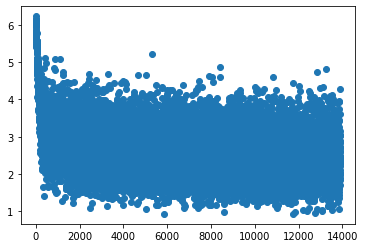

Iteration:  85%|█████████████████████████████████████████████████████████████████████████████████████████▏               | 14000/16493 [3:26:31<45:46,  1.10s/it]

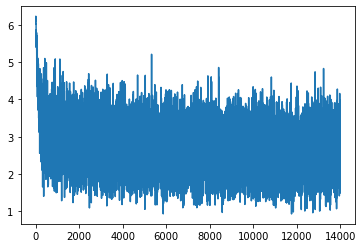

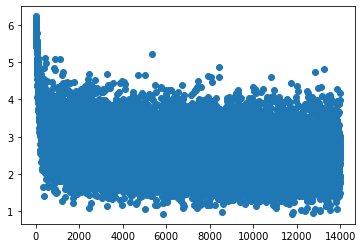

Iteration:  85%|█████████████████████████████████████████████████████████████████████████████████████████▊               | 14100/16493 [3:28:06<45:06,  1.13s/it]

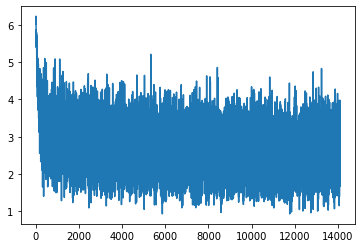

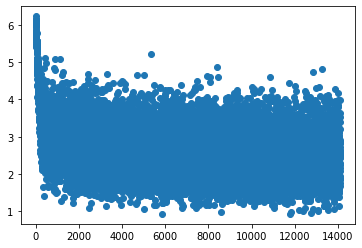

Iteration:  86%|██████████████████████████████████████████████████████████████████████████████████████████▍              | 14200/16493 [3:29:36<36:51,  1.04it/s]

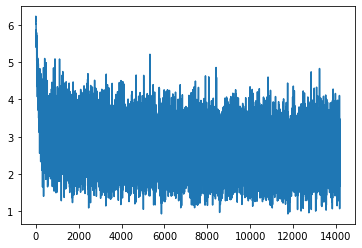

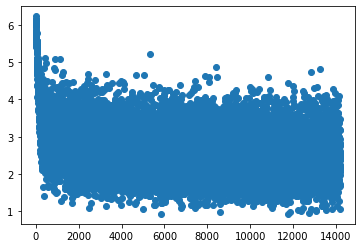

Iteration:  87%|███████████████████████████████████████████████████████████████████████████████████████████              | 14300/16493 [3:31:03<40:42,  1.11s/it]

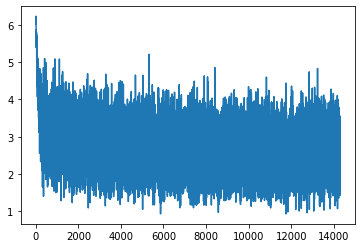

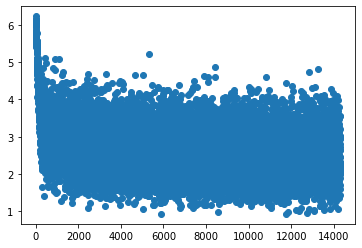

Iteration:  87%|███████████████████████████████████████████████████████████████████████████████████████████▋             | 14400/16493 [3:32:40<27:36,  1.26it/s]

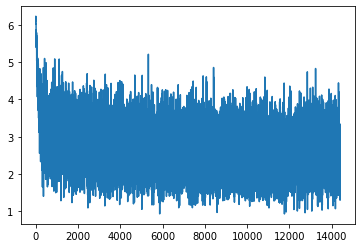

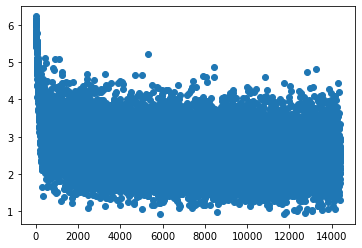

Iteration:  88%|████████████████████████████████████████████████████████████████████████████████████████████▎            | 14500/16493 [3:34:12<31:50,  1.04it/s]

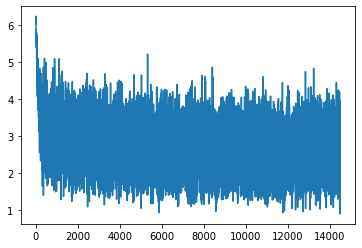

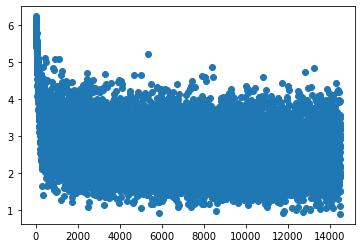

Iteration:  89%|████████████████████████████████████████████████████████████████████████████████████████████▉            | 14600/16493 [3:35:44<35:20,  1.12s/it]

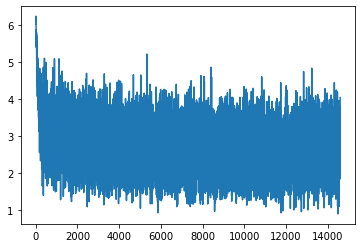

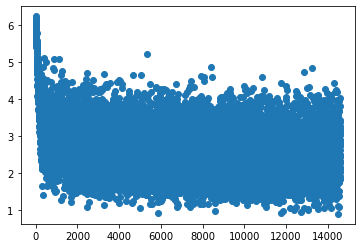

Iteration:  89%|█████████████████████████████████████████████████████████████████████████████████████████████▌           | 14700/16493 [3:37:08<32:54,  1.10s/it]

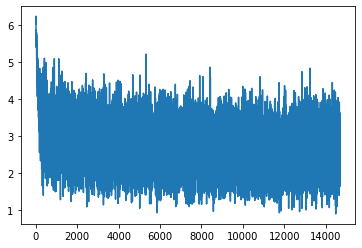

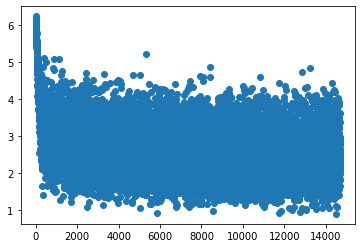

Iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▏          | 14800/16493 [3:38:39<31:16,  1.11s/it]

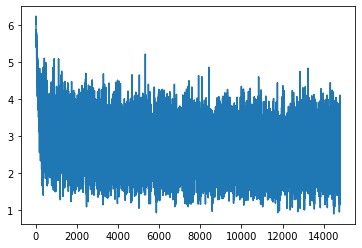

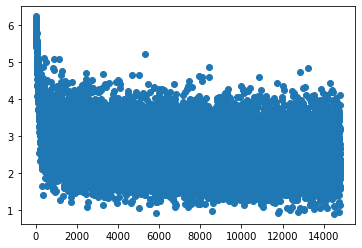

Iteration:  90%|██████████████████████████████████████████████████████████████████████████████████████████████▊          | 14900/16493 [3:40:09<22:06,  1.20it/s]

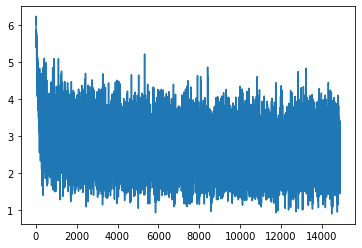

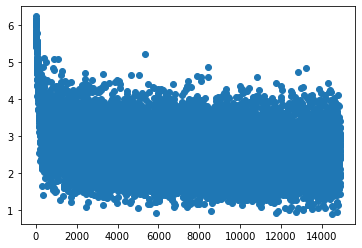

Iteration:  91%|███████████████████████████████████████████████████████████████████████████████████████████████▍         | 15000/16493 [3:41:33<19:01,  1.31it/s]

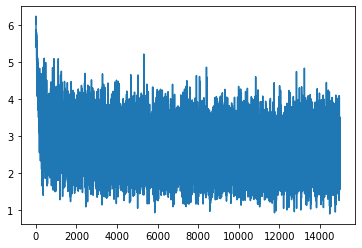

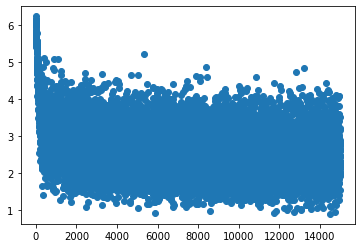

Iteration:  92%|████████████████████████████████████████████████████████████████████████████████████████████████▏        | 15100/16493 [3:43:05<22:02,  1.05it/s]

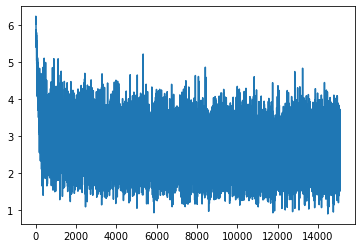

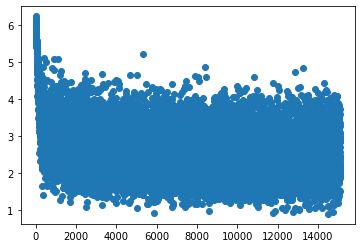

Iteration:  92%|████████████████████████████████████████████████████████████████████████████████████████████████▊        | 15200/16493 [3:44:33<16:18,  1.32it/s]

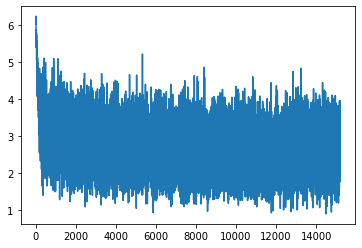

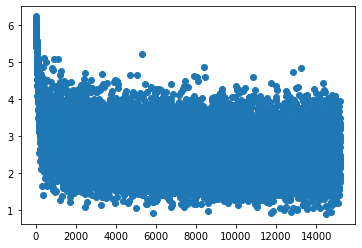

Iteration:  93%|█████████████████████████████████████████████████████████████████████████████████████████████████▍       | 15300/16493 [3:46:00<23:25,  1.18s/it]

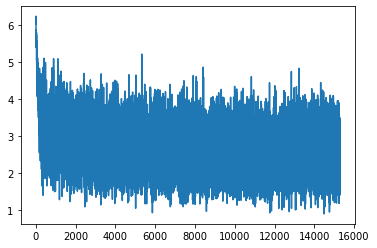

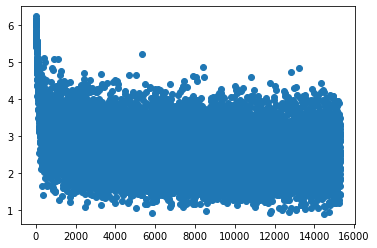

Iteration:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████       | 15400/16493 [3:47:35<20:06,  1.10s/it]

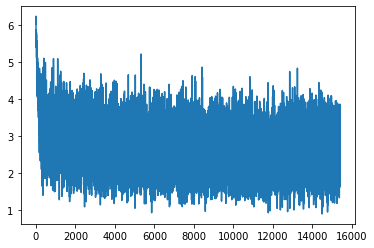

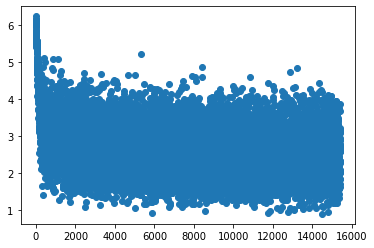

Iteration:  94%|██████████████████████████████████████████████████████████████████████████████████████████████████▋      | 15500/16493 [3:49:06<13:32,  1.22it/s]

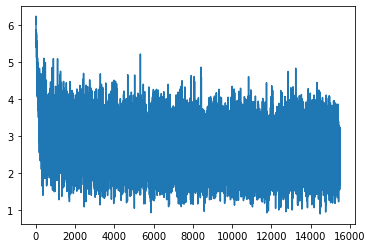

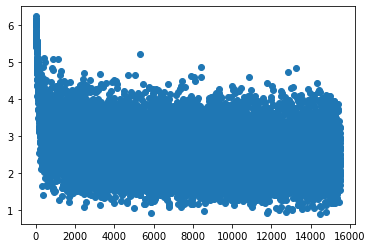

Iteration:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████▎     | 15600/16493 [3:50:29<14:16,  1.04it/s]

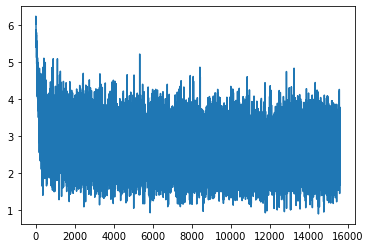

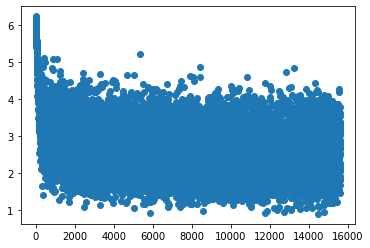

Iteration:  95%|███████████████████████████████████████████████████████████████████████████████████████████████████▉     | 15700/16493 [3:52:09<13:21,  1.01s/it]

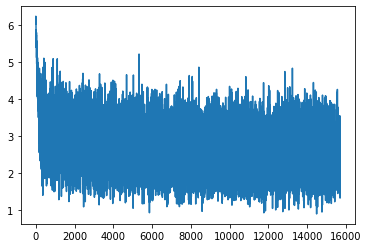

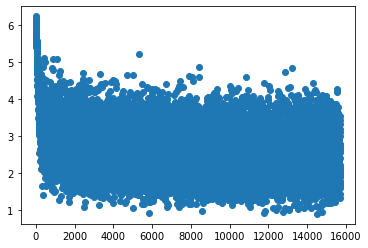

Iteration:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 15800/16493 [3:53:33<11:10,  1.03it/s]

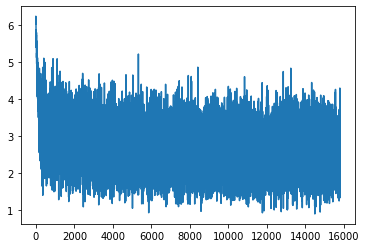

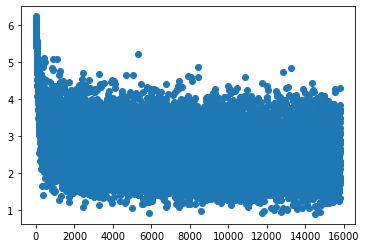

Iteration:  96%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 15900/16493 [3:55:01<07:53,  1.25it/s]

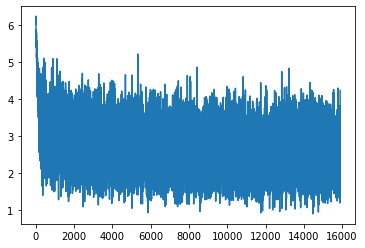

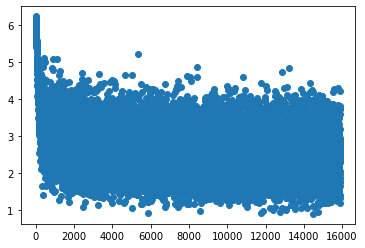

Iteration:  97%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 16000/16493 [3:56:31<07:18,  1.12it/s]

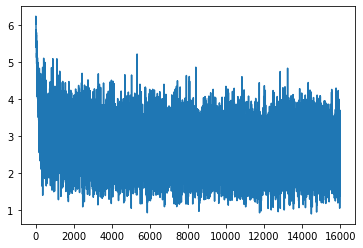

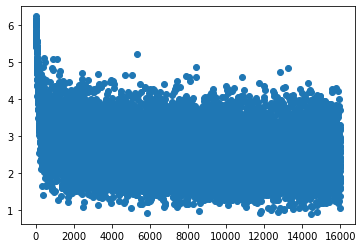

Iteration:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 16100/16493 [3:57:56<05:36,  1.17it/s]

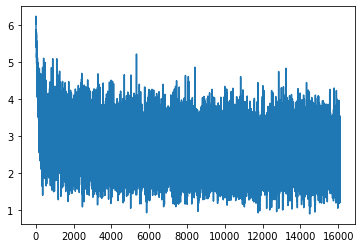

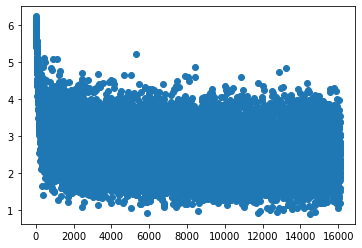

Iteration:  98%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 16200/16493 [3:59:35<04:56,  1.01s/it]

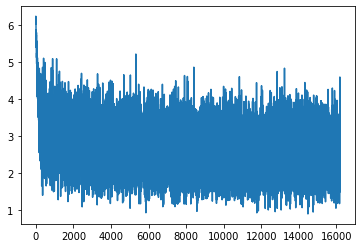

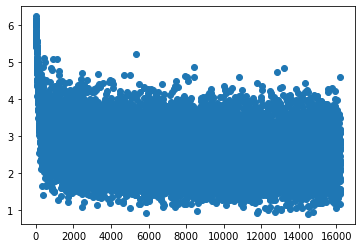

Iteration:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 16300/16493 [4:01:04<02:40,  1.21it/s]

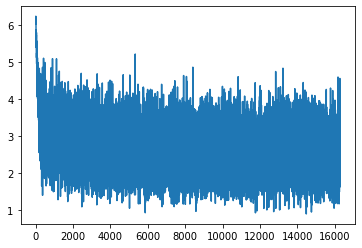

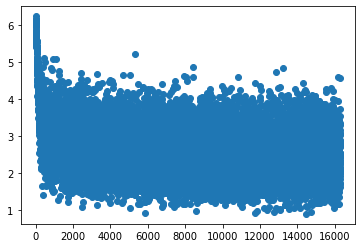

Iteration:  99%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 16400/16493 [4:02:40<01:29,  1.04it/s]

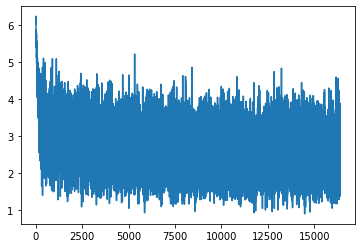

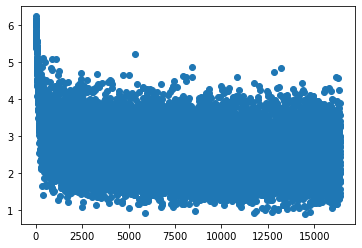

Iteration:   0%|                                                                                                                       | 0/16493 [00:00<?, ?it/s]

Epoch loss 43816.15277993679
Epoch 1 complete, saving probes
Training epoch: 2


Iteration:   1%|▋                                                                                                          | 100/16493 [01:29<4:36:05,  1.01s/it]

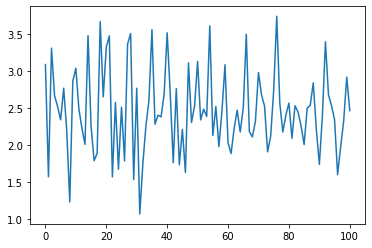

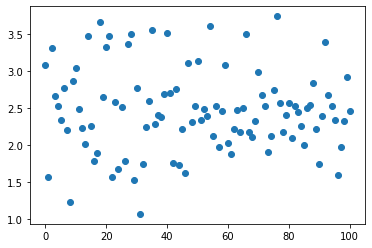

Iteration:   1%|█▎                                                                                                         | 200/16493 [02:56<9:18:19,  2.06s/it]

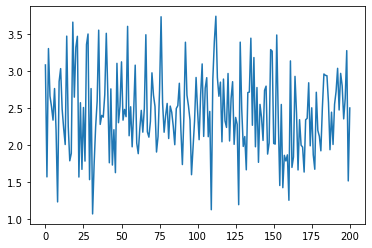

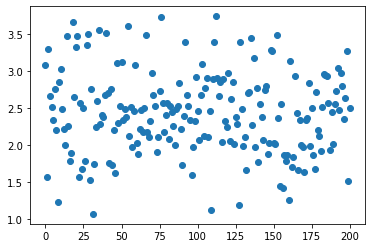

Iteration:   2%|█▉                                                                                                         | 300/16493 [04:26<3:53:26,  1.16it/s]

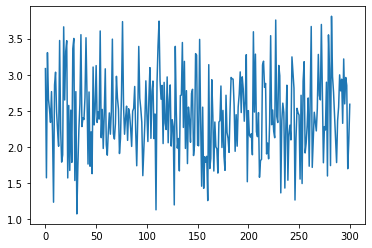

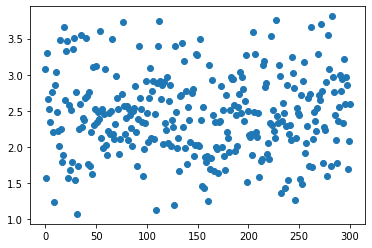

Iteration:   2%|██▌                                                                                                        | 400/16493 [05:51<3:46:18,  1.19it/s]

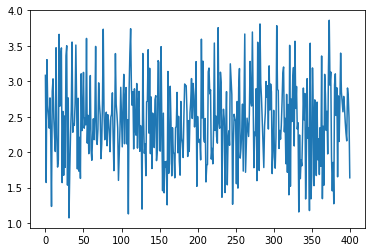

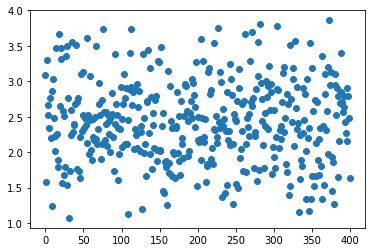

Iteration:   3%|███▏                                                                                                       | 500/16493 [07:20<3:47:10,  1.17it/s]

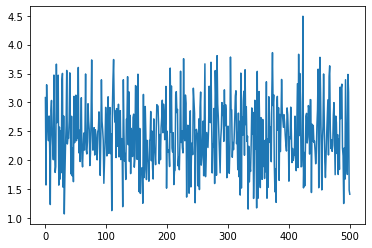

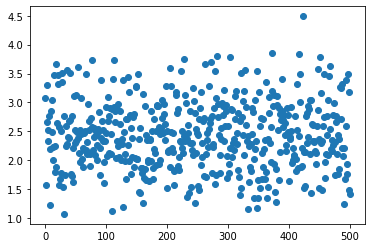

Iteration:   4%|███▉                                                                                                       | 600/16493 [08:52<4:57:29,  1.12s/it]

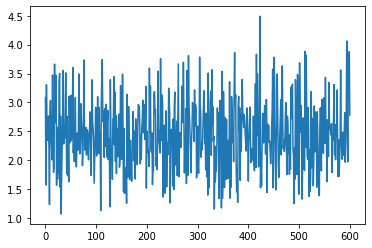

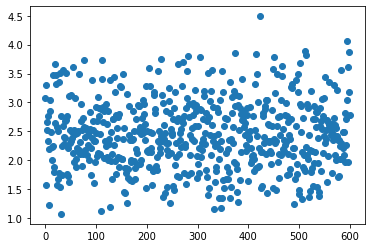

Iteration:   4%|████▌                                                                                                      | 700/16493 [10:18<3:53:04,  1.13it/s]

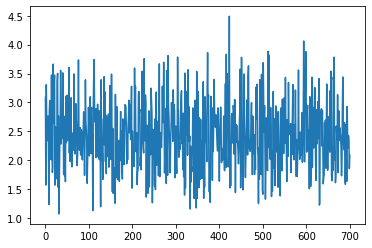

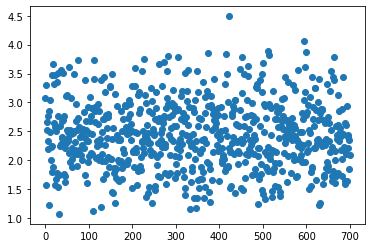

Iteration:   5%|█████▏                                                                                                     | 800/16493 [11:50<4:34:28,  1.05s/it]

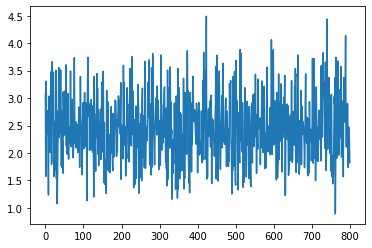

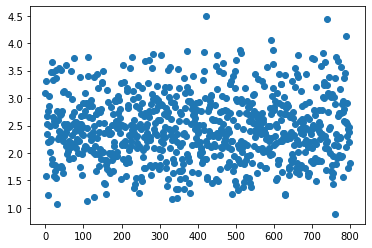

Iteration:   5%|█████▊                                                                                                     | 900/16493 [13:25<3:26:08,  1.26it/s]

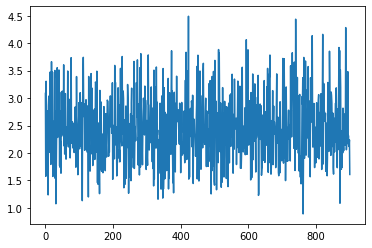

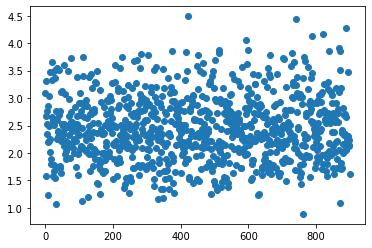

Iteration:   6%|██████▍                                                                                                   | 1000/16493 [14:59<3:20:20,  1.29it/s]

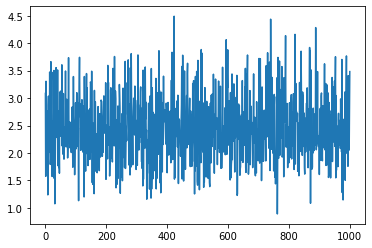

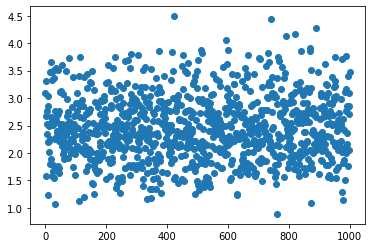

Iteration:   7%|███████                                                                                                   | 1100/16493 [16:27<4:23:03,  1.03s/it]

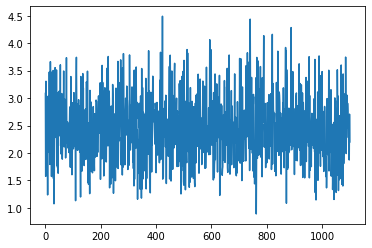

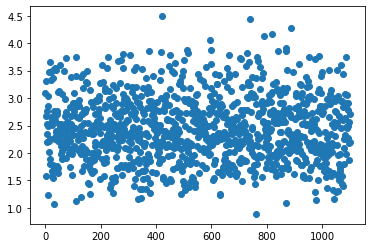

Iteration:   7%|███████▋                                                                                                  | 1200/16493 [18:03<4:38:08,  1.09s/it]

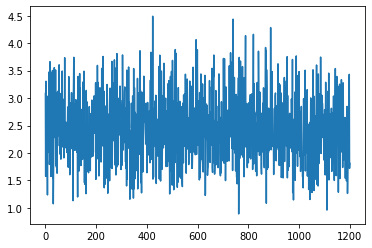

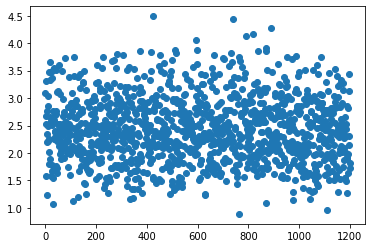

Iteration:   8%|████████▎                                                                                                 | 1300/16493 [19:30<3:31:09,  1.20it/s]

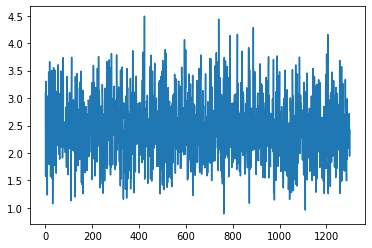

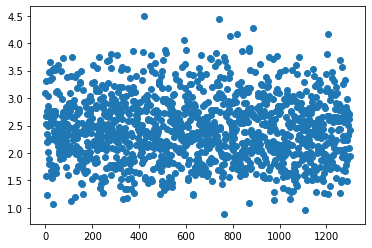

Iteration:   8%|████████▉                                                                                                 | 1400/16493 [21:08<4:00:50,  1.04it/s]

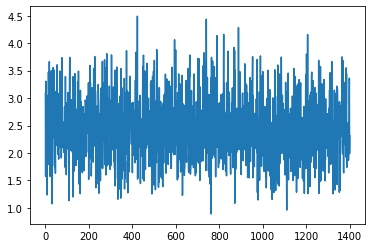

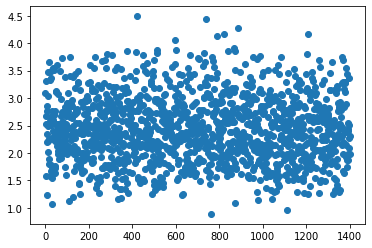

Iteration:   9%|█████████▋                                                                                                | 1500/16493 [22:33<3:18:27,  1.26it/s]

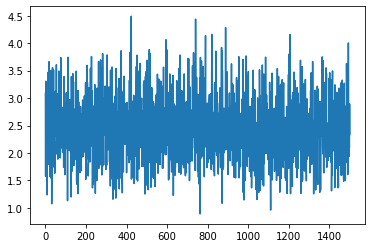

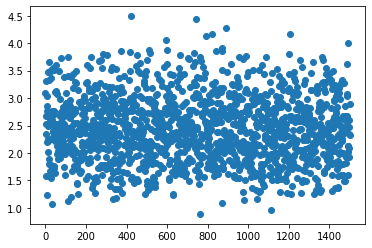

Iteration:  10%|██████████▎                                                                                               | 1600/16493 [24:13<4:44:56,  1.15s/it]

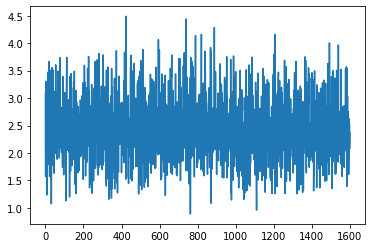

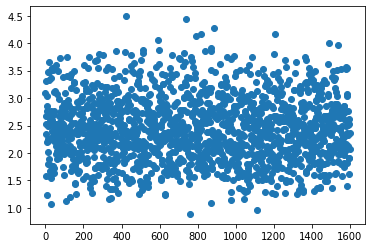

Iteration:  10%|██████████▉                                                                                               | 1700/16493 [25:43<3:36:07,  1.14it/s]

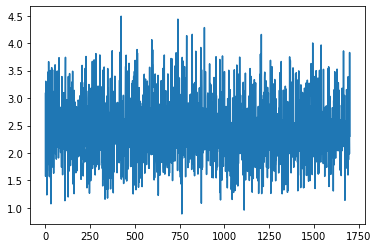

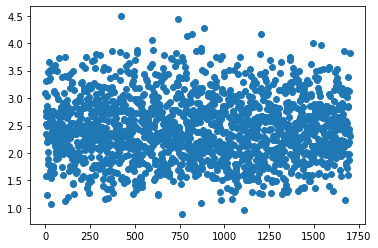

Iteration:  11%|███████████▌                                                                                              | 1800/16493 [27:12<4:33:49,  1.12s/it]

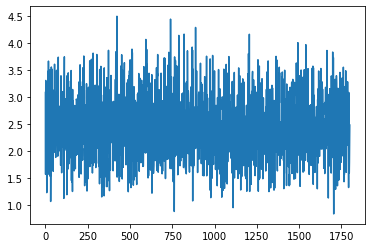

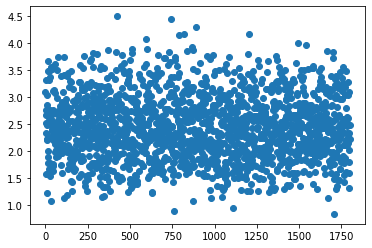

Iteration:  12%|████████████▏                                                                                             | 1900/16493 [28:41<3:15:37,  1.24it/s]

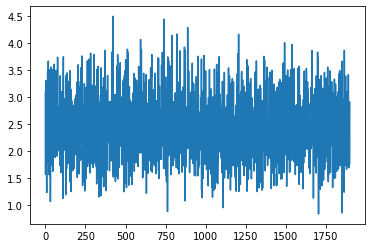

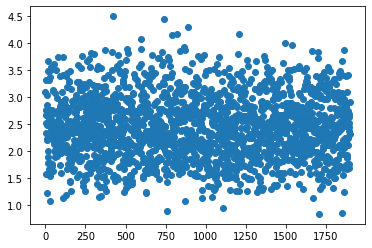

Iteration:  12%|████████████▊                                                                                             | 2000/16493 [30:15<3:46:32,  1.07it/s]

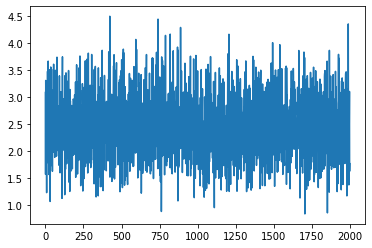

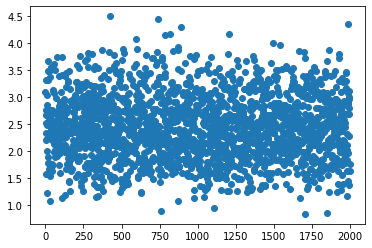

Iteration:  12%|████████████▉                                                                                             | 2013/16493 [30:27<3:24:43,  1.18it/s]

In [ ]:
# Training epochs
for epoch in range(epochs):
    
    # create each epochs folder    
    epoch_dir = "results"+"/"+ model_prefix + "/"+"epoch_" + str(epoch + 1)
    if not os.path.exists(epoch_dir):
        os.mkdir(epoch_dir)
    
    print("Training epoch: {}".format(epoch+1))
    adaptor_s.train()
    adaptor_e.train()

    # Track epoch loss
    epoch_loss = 0

    # Initialize train data loader
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler = train_sampler, batch_size = batch_size)
    loss_list = []
    
    iter=0
    for batch in tqdm(train_dataloader, desc = "Iteration"):
        
        # Get batch on the right device and prepare input dict
        batch = tuple(t.to(device) for t in batch)

        inputs = {
            "input_ids": batch[0],
            "attention_mask": batch[1],
            "token_type_ids": batch[2],
            "start_positions": batch[3],
            "end_positions": batch[4],
        }

        # BERT forward pass
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        # Extract hiddent states
        all_layer_hidden_states = outputs[3][1:] # (layers, batch_size, max_seq_len, hidden_size)
        # Get labels, and update probes for batch
        start_targets = batch[3] # (batch_size)
        end_targets  = batch[4] # (batch_size)
        
        # in: (layers, batch_size, max_seq_len, hidden_size)
        # out: (layers, batch_size, max_seq_len, 1)
#         print(torch.stack(list(all_layer_hidden_states)).size())# ->　torch.Size([12, 8, 384, 768])
        s_scores = adaptor_s(list(all_layer_hidden_states)).squeeze() 
#         print(s_scores.size())
        e_scores = adaptor_e(list(all_layer_hidden_states)).squeeze()      
        
        ignored_index = s_scores.size(1)
        size_of_batch = s_scores.size(0)
        # print(ignored_index) 384
        s_scores.clamp_(0, ignored_index) # (8, 384)
        e_scores.clamp_(0, ignored_index) # (8, 384)
        
        start_loss = nn.CrossEntropyLoss(
            weight = None, ignore_index=ignored_index)(s_scores, start_targets)
        end_loss = nn.CrossEntropyLoss(
            weight = None, ignore_index=ignored_index)(e_scores, end_targets)

        loss = (1.5*start_loss+end_loss)/2.5
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(
            adaptor_s.parameters(), max_grad_norm)
        torch.nn.utils.clip_grad_norm_(
            adaptor_e.parameters(), max_grad_norm)

        start_optimizer.step()
        end_optimizer.step()

        adaptor_s.zero_grad()
        adaptor_e.zero_grad()
        
        batch_loss = float(loss)
        loss_list.append(batch_loss)
        
        if (iter != 0 and iter%100==0):
            plt.plot(loss_list)
            plt.show()
            plt.plot(loss_list,'o')
            plt.show()
        
        epoch_loss+=batch_loss
        iter+=1
        
        # store min loss's hidden state
        if iter % 100 == 0:
            torch.save(adaptor_s.state_dict(), epoch_dir + "/" + "_start_idx_per100")
            torch.save(adaptor_e.state_dict(), epoch_dir + "/" + "_end_idx_per100")
        if batch_loss < min_loss:
            torch.save(adaptor_s.state_dict(), epoch_dir + "/" + "_start_idx")
            torch.save(adaptor_e.state_dict(), epoch_dir + "/" + "_end_idx")
            min_loss = batch_loss        

    print("Epoch loss {}".format(epoch_loss))
    print("Epoch {} complete, saving probes".format(epoch+1))